<a href="https://colab.research.google.com/github/janakan97/Evol-AutoNN/blob/main/Evol_AutoNN1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evol-AutoNN 1.0
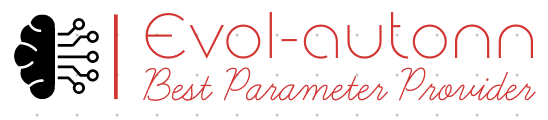


Evol-AutoNN is an application developed with darwins concept of evolution which is an biology the change in the gene of species in several generation to automatate the process of neural network for tabular data. 

The Intial Set of work and the documentation of the project

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

# Works in all flows of the project

# Intial Project documentation  

Dateset Path

**`phoneme data`**

/content/drive/MyDrive/Dataset/phoneme/train.csv

**`amazon-employee data`**

/content/drive/MyDrive/Dataset/amazon-employee/train.csv

**`aps failure`**

/content/drive/MyDrive/Dataset/aps_failure/train.csv

# Validation Container

Setup

In [ ]:
# Getting useful tabular processing and generator functions
!git clone https://github.com/lmassaron/deep_learning_for_tabular_data.git

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import csv
from collections import Counter

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
!pip install wandb



Cloning into 'deep_learning_for_tabular_data'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 64 (delta 32), reused 23 (delta 8), pack-reused 0
Unpacking objects: 100% (64/64), done.
     |████████████████████████████████| 1.8MB 9.5MB/s 
     |████████████████████████████████| 143kB 56.2MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 174kB 55.0MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=9c876303994ba5943bc23e6e53e64d2813f445dec4a60450eff3cd90c21fb600
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=00f0c0373683aa349a6b942359272132bf8ec925b5a1106dc2779f6ffd6e961b
  Stored in

Data Collection
Once the mounting with the drive is done user will be prompted with the link to select the google drive which has the dataset and provied the location

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
location = input("Enter the drive location : ")

Enter the drive location : /content/drive/MyDrive/Dataset/adult/adult.csv


In [ ]:
#X - train data 
X= pd.read_csv(location)
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
target = input("Enter the target variable : ")

Enter the target variable : income


# Preprocessing

In [ ]:

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

In [ ]:
# Transforming all the labels of all variables
from sklearn.preprocessing import LabelEncoder


def preprocess(target,X):
  y = X[target]
  # summarize observations by class label
  counter = Counter(y) 
  key, value = counter.items() 
  # y - It is the taget contating the column provided by the user
  y = X[target].apply(lambda x: 1 if x == key[0] else 0).values
  X.drop([target], axis=1, inplace=True)

  label_encoders = [LabelEncoder() for _ in range(X.shape[1])]

  for col, column in enumerate(X.columns):
    label_encoders[col].fit(X[column])
    X[column] = label_encoders[col].transform(X[column])

  for column in X.columns:
    train_values, test_values = frequency_encoding(column, X)
    X[column + '_counts'] = train_values

  # Pointing out which variables are categorical and which are numeric
  categorical_variables = [col for col in X.columns if '_counts' not in col]
  numeric_variables = [col for col in X.columns if '_counts' in col]

  return categorical_variables, numeric_variables, X, y


# **Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from keras.losses import binary_crossentropy

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score,accuracy_score
from sklearn.metrics import accuracy_score,average_precision_score

import matplotlib.pyplot as plt

## Activation Functions

In [ ]:
# Registering custom activations suitable for tabular problems

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from deep_learning_for_tabular_data.tabular import gelu, Mish, mish

### gelu

In [ ]:
# Add gelu so we can use it as a string
get_custom_objects().update({'gelu': Activation(gelu)})

###Mish

In [ ]:
# Add mish so we can use it as a string
get_custom_objects().update({'mish': Mish(mish)})

###LeakyRelu

In [ ]:
# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

###Architecture

In [ ]:
# Parametric architecture
def tabular_dnn(numeric_variables, categorical_variables, categorical_counts,first_dense,second_dense,activation_type,
                feature_selection_dropout=0.2, categorical_dropout=0.1, dense_dropout = 0.2):
    
    print("The number neurons in the first layer")
    print(first_dense)
    print("The number neurons in the second layer")
    print(second_dense)
    print("The activation type ")
    print(activation_type)

    numerical_inputs = Input(shape=(len(numeric_variables),))
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(feature_selection_dropout)(numerical_normalization)

    categorical_inputs = []
    categorical_embeddings = []
    for category in  categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      int(np.log1p(category_counts)+1), 
                      name = category + "_embed")(categorical_inputs[-1]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(categorical_dropout)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])

    x = concatenate([numerical_feature_selection, categorical_logits])
    x = Dense(first_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)  
    x = Dense(second_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model([numerical_inputs] + categorical_inputs, output)
    
    return model

In [ ]:
# Useful functions

from tensorflow.keras.metrics import AUC

def mAP(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [ ]:
# Global training settings
SEED = 42
FOLDS = 3
BATCH_SIZE = 512

In [ ]:
# Defining callbacks

measure_to_monitor = 'val_auc' 
modality = 'max'

early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                               mode=modality, 
                               patience=3, 
                               verbose=0)

model_checkpoint = ModelCheckpoint('best.model', 
                                   monitor=measure_to_monitor, 
                                   mode=modality, 
                                   save_best_only=True, 
                                   verbose=0)

In [ ]:
from deep_learning_for_tabular_data.tabular import TabularTransformer, DataGenerator
import time
# Setting the CV strategy

def algorithm_learner(first_neuron,second_neuron,activation_type,numeric_variables,categorical_variables,X,y):
  
    skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

    # CV Iteration
    roc_auc = list()
    average_precision = list()
    oof = np.zeros(len(X))
    best_iteration = list()
    start_time = time. time()

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
     
        tb = TabularTransformer(numeric = numeric_variables,ordinal = [],lowcat  = [],
                            highcat = categorical_variables)

        tb.fit(X.iloc[train_idx])
        sizes = tb.shape(X.iloc[train_idx])
        categorical_levels = dict(zip(categorical_variables, sizes[1:]))
        print(f"Input array sizes: {sizes}")
        print(f"Categorical levels: {categorical_levels}\n")
     
        model = tabular_dnn(numeric_variables, categorical_variables,categorical_levels, first_neuron,second_neuron,activation_type,
                        feature_selection_dropout=0.1,categorical_dropout=0.1, dense_dropout = 0.1 )
   
        model = compile_model(model, binary_crossentropy, [AUC(name='auc'), mAP], Adam(learning_rate=0.0001))
    
        train_batch = DataGenerator(X.iloc[train_idx], 
                                y[train_idx],
                                tabular_transformer=tb,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    
     
        history = model.fit(train_batch,
                        validation_data=(tb.transform(X.iloc[test_idx]), y[test_idx]),
                        epochs=10,
                        callbacks=[model_checkpoint, early_stopping],
                        class_weight={0:1.0, 1:(np.sum(y==0) / np.sum(y==1))},
                        verbose=1)
    
        print("\nFOLD %i" % fold)
        plot_keras_history(history, measures=['auc', 'loss'])
    
        best_iteration.append(np.argmax(history.history['val_auc']) + 1)
        preds = model.predict(tb.transform(X.iloc[test_idx]),
                          verbose=1,
                          batch_size=1024).flatten()

        oof[test_idx] = preds

        roc_auc.append(roc_auc_score(y_true=y[test_idx], y_score=preds))
        average_precision.append(average_precision_score(y_true=y[test_idx], y_score=preds))

        

        print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
        print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

        score_roc_auc=roc_auc_score(y_true=y, y_score=oof)
        print("Roc auc score OOF %0.3f" % score_roc_auc )
        avg_pre_acr=average_precision_score(y_true=y, y_score=oof)
        print("Average precision OOF %0.3f" % avg_pre_acr )

        return (avg_pre_acr+score_roc_auc)/2
    


# **Evolutionary Algorithm**


##Decoder

In [ ]:

from numpy.random import randint
from numpy.random import rand


def decoder(x):
    #Total length of chromosome is divided into 2 
    f_layer = x[:6]
    s_layer = x[6:13]
    a_function = x[13:15]
    a_function=int(''.join(map(lambda a_function: str(int(a_function)), a_function)), 2)
    if a_function == 1:
      a_function = 'gelu'
      if a_function == 2:
        a_function = 'mish'
    else:
      a_function ='leaky-relu'
    #Divide chromosomes create the number for neurons in the layer
    f_neurons=1+int(''.join(map(lambda f_layer: str(int(f_layer)), f_layer)), 2)
    s_neurons=1+int(''.join(map(lambda s_layer: str(int(s_layer)), s_layer)), 2)
    print("First layer nerons", f_neurons)
    print("Second layer nerons",s_neurons)
    print("The activation function", a_function)
    return f_neurons, s_neurons, a_function ; 

##Objective Function

In [ ]:

# objective function for the neural network
def objective(x,categorical_variables,numeric_variables,X,y):
    f_neurons,s_neurons, activation = decoder(x)
    avg_score=algorithm_learner(f_neurons,s_neurons,activation,numeric_variables,categorical_variables,X,y)
    print("returnig the avg_score")
    return avg_score

##Operation of GA

###Selection

In [ ]:
# tournament selection
def selection(pop, scores, k=3):
	  # first random selection
	  selection_ix = randint(len(pop))
	  for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		  if scores[ix] > scores[selection_ix]:
			  selection_ix = ix
	  return pop[selection_ix]


###Crossover

In [ ]:

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() > r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]


###Mutation

In [ ]:
# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() > r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

##Genetic Algorithm

In [ ]:
# genetic algorithm
def genetic_algorithm(B_sec, objective,categorical_variables,numeric_variables,X,y, n_gen, n_pop, r_cross, r_mut):
  n_bits = 15
  # initial population of random bitstring
  pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
  # printing the initilized population
  print("The population")
  for x in range(len(pop)):
    print(pop[x])

  starting_time = time.time()
  # keep track of best solution
  best, best_eval = 0, objective(pop[0],categorical_variables,numeric_variables,X,y)
  trained_time=0
  
  while (B_sec >= trained_time):
    # evaluate all candidates in the population
    scores = [objective(c,categorical_variables,numeric_variables,X,y) for c in pop]

    print("Budget in sec", B_sec)
    print("Train time", trained_time)

  # check for new best solution
    for i in range(n_pop):
      if scores[i] > best_eval:
        best, best_eval = pop[i], scores[i]
        print(">%d, new best f(%s) = %.3f" % (n_gen, pop[i], scores[i]))
  # select parents

    selected = [selection(pop, scores) for _ in range(n_pop)]

  # create the next generation
    children = list()

    for i in range(0, n_pop, 2):
    # get selected parents in pairs
      p1, p2 = selected[i], selected[i + 1]
    # crossover and mutation
      for c in crossover(p1, p2, r_cross):
      # mutation
        mutation(c, r_mut)
      # store for next generation
        children.append(c)
  # replace population
    pop = children
    trained_time = time.time() - starting_time

  return [best, best_eval]





In [ ]:
# genetic algorithm
def genetic_algorithmforparam(objective,categorical_variables,numeric_variables,X,y, n_gen, n_pop, r_cross, r_mut):
  n_bits = 15
  print ("number of  gen", n_gen)
  print ("number of  pop", n_pop)
  print ("number of  cross", r_cross)
  print ("number of  mut", r_mut)
  # initial population of random bitstring
  pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
  # printing the initilized population
  print("The population")
  for x in range(len(pop)):
    print(pop[x])

  starting_time = time.time()
  # keep track of best solution
  best, best_eval = 0, objective(pop[0],categorical_variables,numeric_variables,X,y)

  
  
  # evaluate all candidates in the population
  scores = [objective(c,categorical_variables,numeric_variables,X,y) for c in pop]



  # check for new best solution
  for i in range(n_pop):
   if scores[i] > best_eval:
     best, best_eval = pop[i], scores[i]
     print(">%d, new best f(%s) = %.3f" % (n_gen, pop[i], scores[i]))
  # select parents

  selected = [selection(pop, scores) for _ in range(n_pop)]

  # create the next generation
  children = list()

  for i in range(0, n_pop, 2):
    # get selected parents in pairs
    p1, p2 = selected[i], selected[i + 1]
    # crossover and mutation
    for c in crossover(p1, p2, r_cross):
      # mutation
      mutation(c, r_mut)
      # store for next generation
      children.append(c)
  # replace population
  pop = children
    

  return [best, best_eval]





In [ ]:
def EvolAutoNN(target,X):
    print(target)
    target=str(target)
    categorical_variables, numeric_variables, X, y =preprocess(target,X)
    X, X_test, y, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)
    print(categorical_variables)
    option = input("Selection the option to run : \n 1. Run with Budget \n 2. Change the configuration \n ")
    if(option == "1"):
      print("Budget Available :- 1hour , 2hour , 3hour")
      budget = input("Enter the Budget : ")
      #convert the budget to secod
      B_sec = int(budget)*60*60
      print("learning Begins ")
      best, score = genetic_algorithm(B_sec,objective,categorical_variables,numeric_variables,X,y,n_gen=2,n_pop=10,r_cross= 0.7,r_mut=1.0 / float(15))
    else:
      print("The degfault values used are listed below if you want change type Yes and if you dont want to  change any parameter type No")
      print("No. of generation",2)
      print("No. of poplation",10)
      print("Crossover rate",0.7)
      print("Mutation rate",0.0625)
      n_gen= int(input("Input the number of generation "))
      n_pop= int(input("Input the nmber of population"))
      r_cross= float( input("Input the crossover rate"))
      r_mut= float( input("Input the mutation rate"))
      best, score = genetic_algorithmforparam(objective,categorical_variables,numeric_variables,X,y,n_gen,n_pop,r_cross,r_mut)
    print('Done!')
    print('f(%s) = %f' % (best, score)) 
    return best,categorical_variables,numeric_variables,X_test,y_test,X,y

income
['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Selection the option to run : 
 1. Run with Budget 
 2. Change the configuration 
 1
Budget Available :- 1hour , 2hour , 3hour
Enter the Budget : 1
learning Begins 
The population
[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0]
[1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]
First layer nerons 2
Second layer nerons 27
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Cat

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 2/10
51/51 [==============================] - 4s 80ms/step - loss: 0.3240 - auc: 0.6464 - mAP: 0.8210 - val_loss: 0.6824 - val_auc: 0.6683 - val_mAP: 0.8507


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 3/10
51/51 [==============================] - 4s 82ms/step - loss: 0.3214 - auc: 0.6648 - mAP: 0.8319 - val_loss: 0.6793 - val_auc: 0.6904 - val_mAP: 0.8624


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 4/10
51/51 [==============================] - 4s 80ms/step - loss: 0.3183 - auc: 0.6831 - mAP: 0.8443 - val_loss: 0.6753 - val_auc: 0.7102 - val_mAP: 0.8732


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 5/10
51/51 [==============================] - 4s 81ms/step - loss: 0.3150 - auc: 0.6988 - mAP: 0.8533 - val_loss: 0.6706 - val_auc: 0.7286 - val_mAP: 0.8832


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 6/10
51/51 [==============================] - 4s 81ms/step - loss: 0.3104 - auc: 0.7189 - mAP: 0.8668 - val_loss: 0.6642 - val_auc: 0.7450 - val_mAP: 0.8927


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 7/10
51/51 [==============================] - 4s 81ms/step - loss: 0.3063 - auc: 0.7308 - mAP: 0.8742 - val_loss: 0.6572 - val_auc: 0.7602 - val_mAP: 0.9012


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 8/10
51/51 [==============================] - 4s 80ms/step - loss: 0.3021 - auc: 0.7443 - mAP: 0.8800 - val_loss: 0.6482 - val_auc: 0.7742 - val_mAP: 0.9089


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 9/10
51/51 [==============================] - 4s 81ms/step - loss: 0.2967 - auc: 0.7572 - mAP: 0.8911 - val_loss: 0.6370 - val_auc: 0.7863 - val_mAP: 0.9143


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 10/10
51/51 [==============================] - 4s 82ms/step - loss: 0.2908 - auc: 0.7713 - mAP: 0.8975 - val_loss: 0.6245 - val_auc: 0.7973 - val_mAP: 0.9196


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



FOLD 0


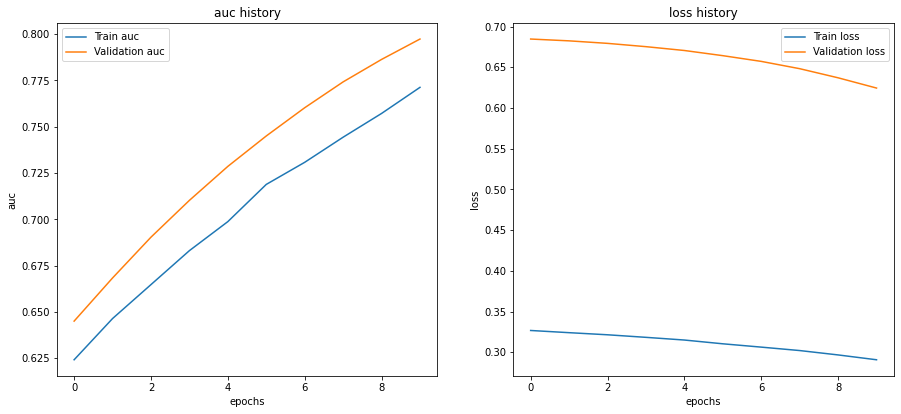

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.797 ± 0.000
Average cv roc average precision 0.913 ± 0.000
Roc auc score OOF 0.533
Average precision OOF 0.811
returnig the avg_score
First layer nerons 2
Second layer nerons 27
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
2
The number neurons in the second layer
27
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3297 - auc: 0.6025 - mAP: 0.8159 - val_loss: 0.6962 - val_auc: 0.6242 - val_mAP: 0.8462
Epoch 2/10
51/51 [==============================] - 4s 81ms/step - loss: 0.3284 - auc: 0

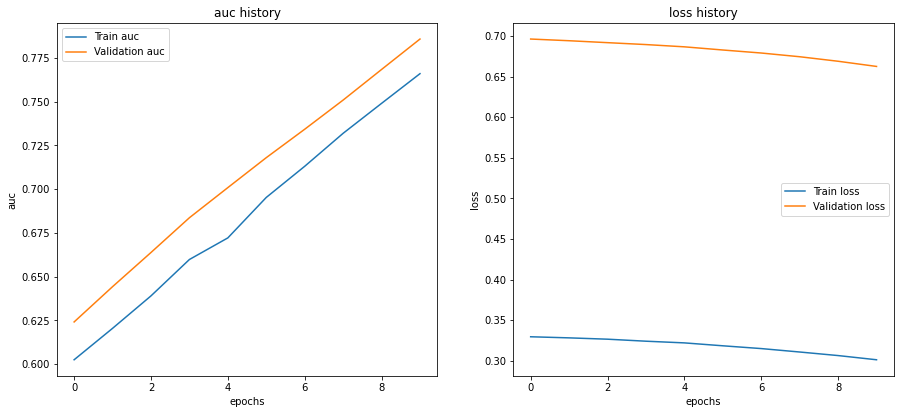

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.786 ± 0.000
Average cv roc average precision 0.915 ± 0.000
Roc auc score OOF 0.532
Average precision OOF 0.811
returnig the avg_score
First layer nerons 64
Second layer nerons 73
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
64
The number neurons in the second layer
73
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 87ms/step - loss: 0.3163 - auc: 0.6821 - mAP: 0.8438 - val_loss: 0.6007 - val_auc: 0.7611 - val_mAP: 0.9040
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 3/10
51/51 [==============================] - 4s 81ms/step - loss: 0.2692 - auc: 0.8071 - mAP: 0.9242 - val_loss: 0.5636 - val_auc: 0.8243 - val_mAP: 0.9363


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 4/10
51/51 [==============================] - 4s 82ms/step - loss: 0.2577 - auc: 0.8188 - mAP: 0.9306 - val_loss: 0.5411 - val_auc: 0.8318 - val_mAP: 0.9399


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 5/10
51/51 [==============================] - 4s 81ms/step - loss: 0.2491 - auc: 0.8276 - mAP: 0.9344 - val_loss: 0.5212 - val_auc: 0.8370 - val_mAP: 0.9416


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 6/10
51/51 [==============================] - 4s 81ms/step - loss: 0.2437 - auc: 0.8319 - mAP: 0.9370 - val_loss: 0.5080 - val_auc: 0.8410 - val_mAP: 0.9433


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 7/10
51/51 [==============================] - 4s 83ms/step - loss: 0.2388 - auc: 0.8381 - mAP: 0.9400 - val_loss: 0.4994 - val_auc: 0.8444 - val_mAP: 0.9449


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 8/10
51/51 [==============================] - 4s 81ms/step - loss: 0.2353 - auc: 0.8424 - mAP: 0.9424 - val_loss: 0.4931 - val_auc: 0.8480 - val_mAP: 0.9462


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 9/10
51/51 [==============================] - 4s 80ms/step - loss: 0.2317 - auc: 0.8472 - mAP: 0.9441 - val_loss: 0.4872 - val_auc: 0.8516 - val_mAP: 0.9477


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


Epoch 10/10
51/51 [==============================] - 4s 82ms/step - loss: 0.2280 - auc: 0.8527 - mAP: 0.9466 - val_loss: 0.4790 - val_auc: 0.8555 - val_mAP: 0.9492


INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



FOLD 0


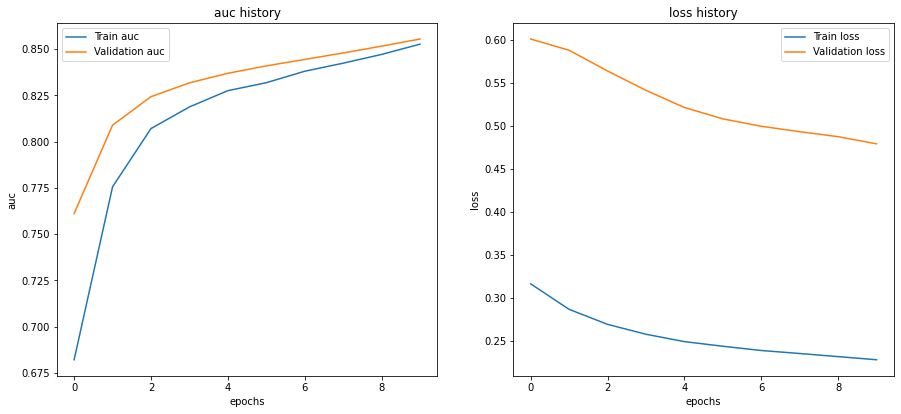

13/13 [==============================] - 0s 3ms/step
Average cv roc auc score 0.855 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 15
Second layer nerons 87
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
15
The number neurons in the second layer
87
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 88ms/step - loss: 0.3385 - auc: 0.4816 - mAP: 0.7412 - val_loss: 0.6909 - val_auc: 0.5578 - val_mAP: 0.7968
Epoch 2/10
51/51 [==============================] - 4s 81ms/step - loss: 0

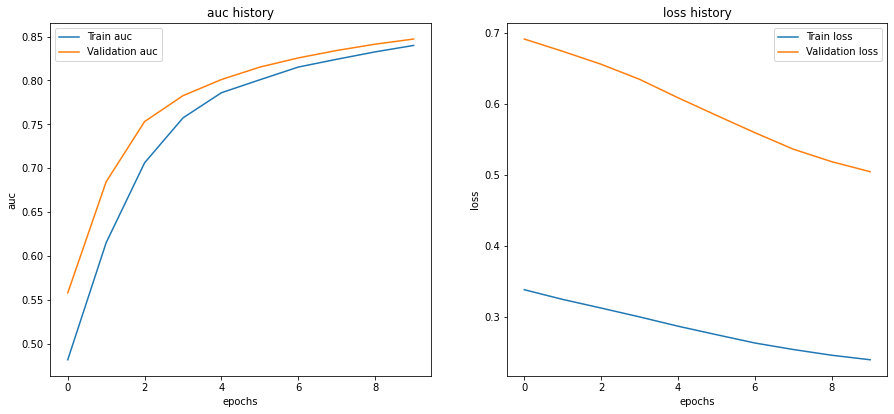

13/13 [==============================] - 0s 3ms/step
Average cv roc auc score 0.847 ± 0.000
Average cv roc average precision 0.944 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 49
Second layer nerons 85
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
49
The number neurons in the second layer
85
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 95ms/step - loss: 0.3293 - auc: 0.5665 - mAP: 0.8015 - val_loss: 0.6589 - val_auc: 0.7008 - val_mAP: 0.8827
Epoch 2/10
51/51 [==============================] - 4s 80ms/step - loss: 0

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



FOLD 0


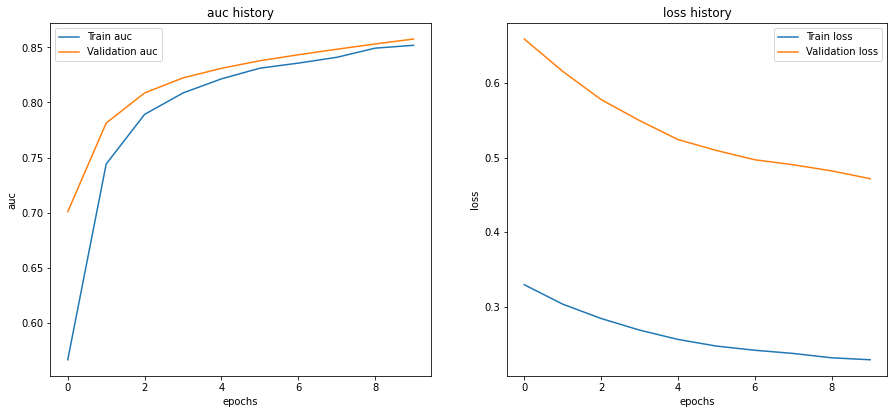

13/13 [==============================] - 0s 3ms/step
Average cv roc auc score 0.858 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 29
Second layer nerons 56
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
29
The number neurons in the second layer
56
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3334 - auc: 0.5628 - mAP: 0.7936 - val_loss: 0.6338 - val_auc: 0.6515 - val_mAP: 0.8541
Epoch 2/10
51/51 [==============================] - 4s 81ms/step - loss: 0

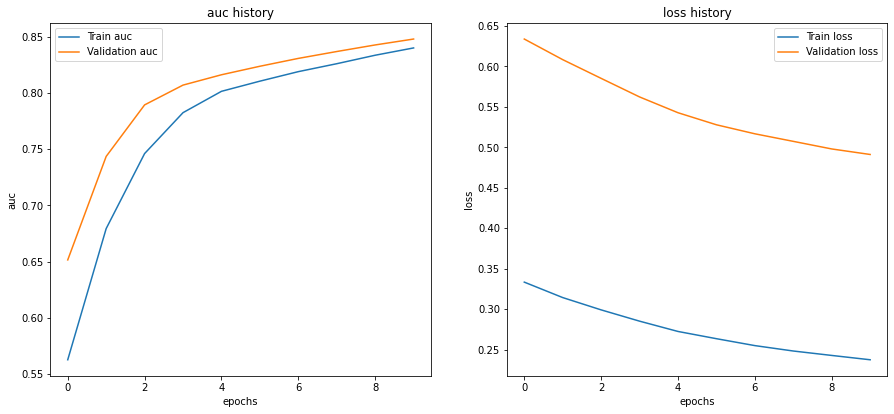

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.848 ± 0.000
Average cv roc average precision 0.944 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 31
Second layer nerons 126
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
31
The number neurons in the second layer
126
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 7s 91ms/step - loss: 0.3249 - auc: 0.6402 - mAP: 0.8175 - val_loss: 0.6712 - val_auc: 0.7271 - val_mAP: 0.8874
Epoch 2/10
51/51 [==============================] - 4s 81ms/step - loss: 0.3094 - au

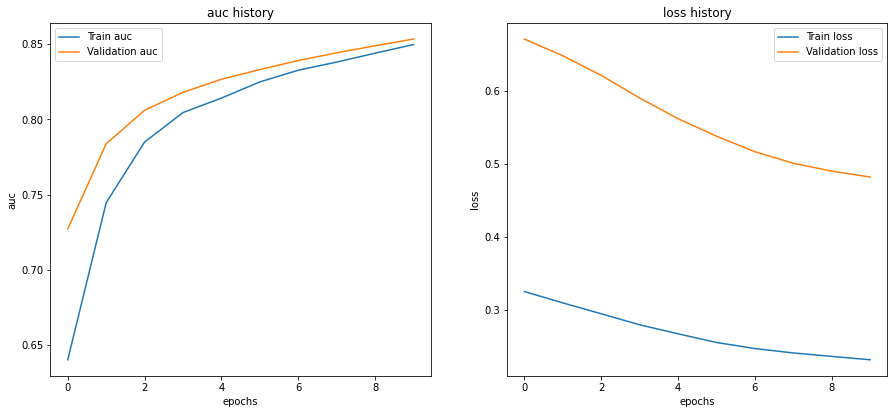

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.853 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 6
Second layer nerons 4
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
6
The number neurons in the second layer
4
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3322 - auc: 0.5840 - mAP: 0.7901 - val_loss: 0.7356 - val_auc: 0.6115 - val_mAP: 0.8211
Epoch 2/10
51/51 [==============================] - 4s 81ms/step - loss: 0.328

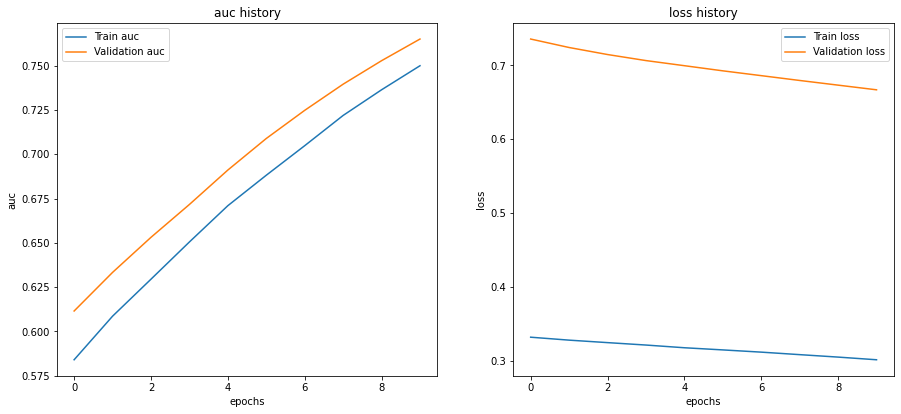

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.765 ± 0.000
Average cv roc average precision 0.892 ± 0.000
Roc auc score OOF 0.529
Average precision OOF 0.804
returnig the avg_score
First layer nerons 15
Second layer nerons 74
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
15
The number neurons in the second layer
74
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 88ms/step - loss: 0.3354 - auc: 0.5206 - mAP: 0.7711 - val_loss: 0.7086 - val_auc: 0.6156 - val_mAP: 0.8314
Epoch 2/10
51/51 [==============================] - 4s 79ms/step - loss: 0

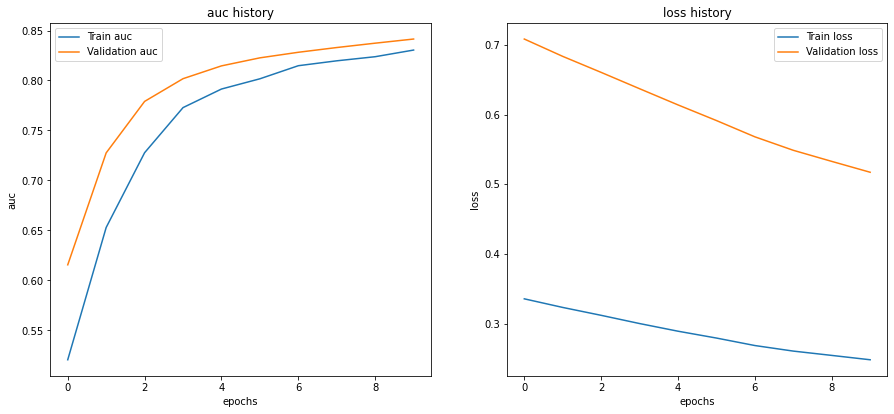

13/13 [==============================] - 0s 3ms/step
Average cv roc auc score 0.842 ± 0.000
Average cv roc average precision 0.939 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.819
returnig the avg_score
First layer nerons 45
Second layer nerons 5
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
45
The number neurons in the second layer
5
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3058 - auc: 0.7225 - mAP: 0.8843 - val_loss: 0.5960 - val_auc: 0.7896 - val_mAP: 0.9211
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0.2

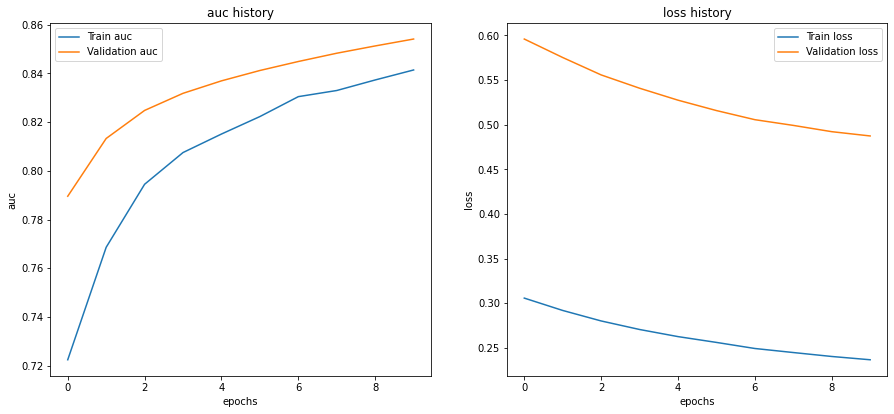

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.854 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 50
Second layer nerons 41
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
50
The number neurons in the second layer
41
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 90ms/step - loss: 0.3076 - auc: 0.6980 - mAP: 0.8676 - val_loss: 0.6260 - val_auc: 0.7753 - val_mAP: 0.9117
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0

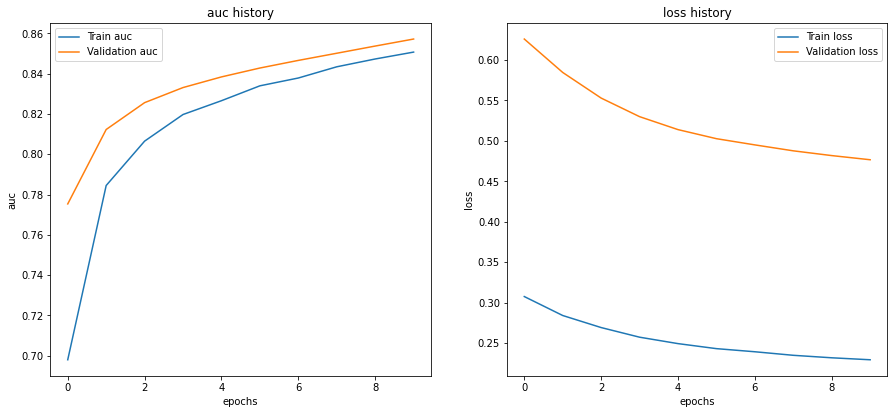

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.857 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
Budget in sec 3600
Train time 0
>2, new best f([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]) = 0.681
>2, new best f([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]) = 0.681
First layer nerons 1
Second layer nerons 124
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
1
The number neurons in the second layer
124
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step 

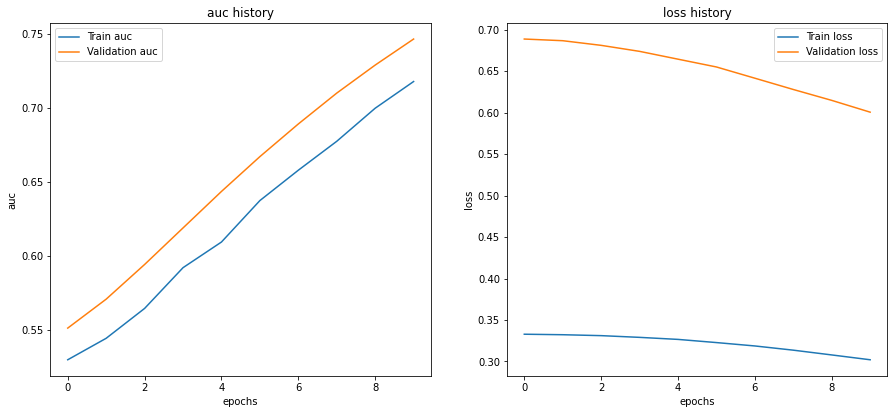

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.747 ± 0.000
Average cv roc average precision 0.891 ± 0.000
Roc auc score OOF 0.527
Average precision OOF 0.803
returnig the avg_score
First layer nerons 39
Second layer nerons 88
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
39
The number neurons in the second layer
88
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3266 - auc: 0.5943 - mAP: 0.8023 - val_loss: 0.6782 - val_auc: 0.7138 - val_mAP: 0.8882
Epoch 2/10
51/51 [==============================] - 4s 81ms/step - loss: 0

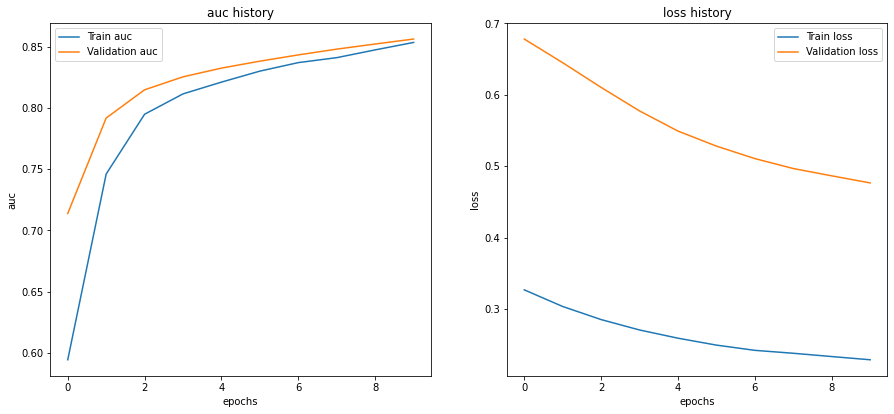

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.856 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 9
Second layer nerons 87
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
9
The number neurons in the second layer
87
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 90ms/step - loss: 0.3432 - auc: 0.4067 - mAP: 0.7082 - val_loss: 0.6691 - val_auc: 0.4569 - val_mAP: 0.7646
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0.3

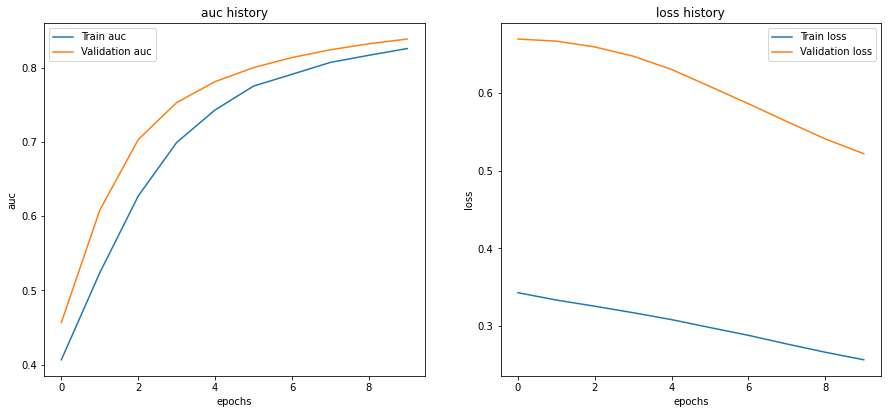

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.838 ± 0.000
Average cv roc average precision 0.940 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 50
Second layer nerons 55
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
50
The number neurons in the second layer
55
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3204 - auc: 0.6360 - mAP: 0.8325 - val_loss: 0.6619 - val_auc: 0.7517 - val_mAP: 0.9003
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0

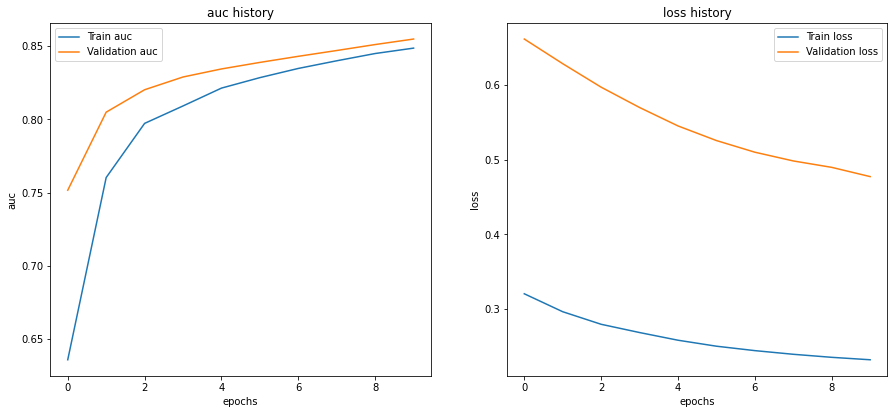

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.855 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 51
Second layer nerons 96
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
51
The number neurons in the second layer
96
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 91ms/step - loss: 0.3272 - auc: 0.5976 - mAP: 0.8128 - val_loss: 0.6388 - val_auc: 0.7517 - val_mAP: 0.8983
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0

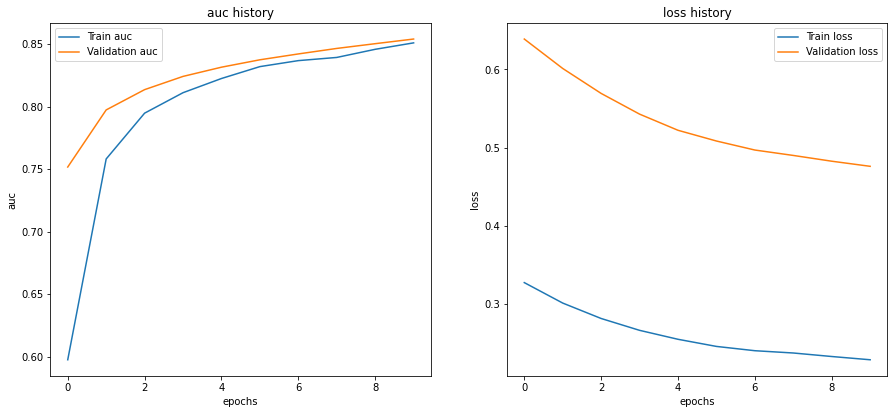

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.854 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 16
Second layer nerons 124
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
16
The number neurons in the second layer
124
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 7s 91ms/step - loss: 0.3282 - auc: 0.6026 - mAP: 0.8177 - val_loss: 0.6668 - val_auc: 0.7093 - val_mAP: 0.8810
Epoch 2/10
51/51 [==============================] - 4s 85ms/step - loss: 0.3166 - au

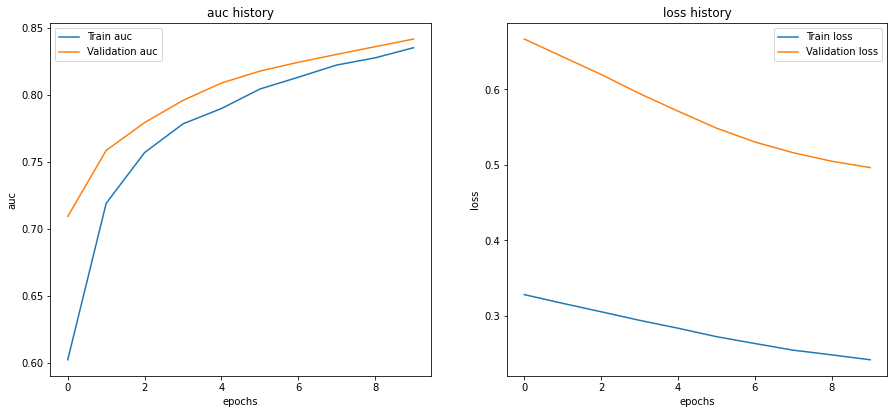

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.841 ± 0.000
Average cv roc average precision 0.940 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 15
Second layer nerons 87
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
15
The number neurons in the second layer
87
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 88ms/step - loss: 0.3270 - auc: 0.6111 - mAP: 0.8145 - val_loss: 0.6537 - val_auc: 0.6893 - val_mAP: 0.8710
Epoch 2/10
51/51 [==============================] - 4s 83ms/step - loss: 0

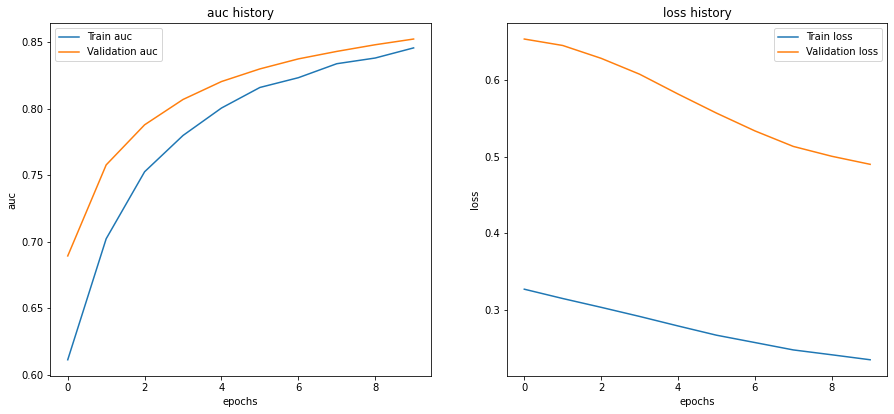

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 15
Second layer nerons 88
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
15
The number neurons in the second layer
88
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 93ms/step - loss: 0.3167 - auc: 0.7247 - mAP: 0.8823 - val_loss: 0.6280 - val_auc: 0.7664 - val_mAP: 0.9075
Epoch 2/10
51/51 [==============================] - 4s 84ms/step - loss: 0.3064 - auc:

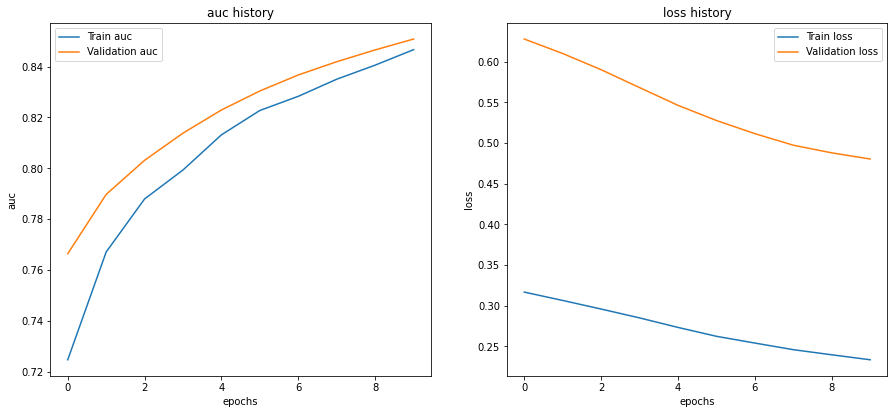

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.851 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 16
Second layer nerons 43
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
16
The number neurons in the second layer
43
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 7s 92ms/step - loss: 0.3366 - auc: 0.4868 - mAP: 0.7615 - val_loss: 0.6848 - val_auc: 0.5443 - val_mAP: 0.8082
Epoch 2/10
51/51 [==============================] - 4s 83ms/step - loss: 0.3284 - auc:

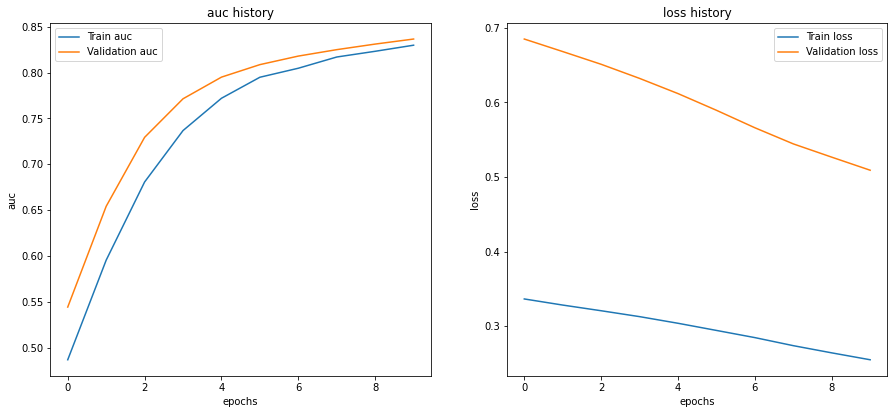

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.837 ± 0.000
Average cv roc average precision 0.939 ± 0.000
Roc auc score OOF 0.537
Average precision OOF 0.819
returnig the avg_score
First layer nerons 1
Second layer nerons 40
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
1
The number neurons in the second layer
40
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 89ms/step - loss: 0.3383 - auc: 0.4793 - mAP: 0.7444 - val_loss: 0.6732 - val_auc: 0.4798 - val_mAP: 0.7713
Epoch 2/10
51/51 [==============================] - 4s 82ms/step - loss: 0.3

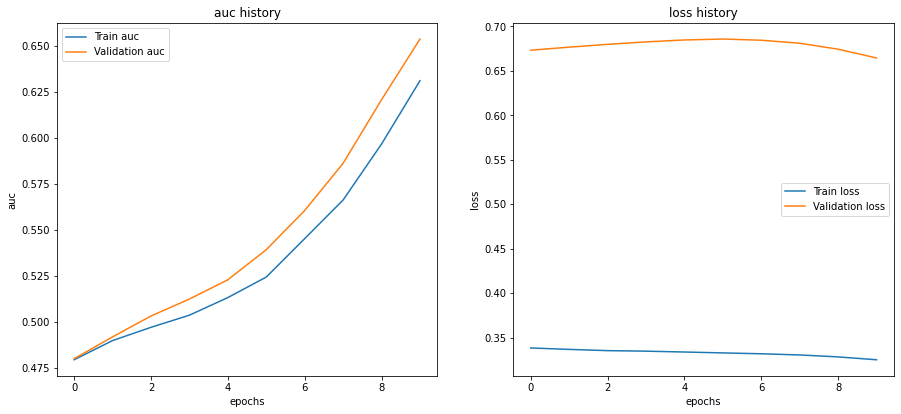

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.655 ± 0.000
Average cv roc average precision 0.848 ± 0.000
Roc auc score OOF 0.517
Average precision OOF 0.789
returnig the avg_score
Budget in sec 3600
Train time 685.6303088665009
First layer nerons 18
Second layer nerons 41
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
18
The number neurons in the second layer
41
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 90ms/step - loss: 0.3324 - auc: 0.5630 - mAP: 0.7837 - val_loss: 0.6689 - val_auc: 0.6252 - val_mAP: 0.8371
Epoch 2/10
51/51 [========

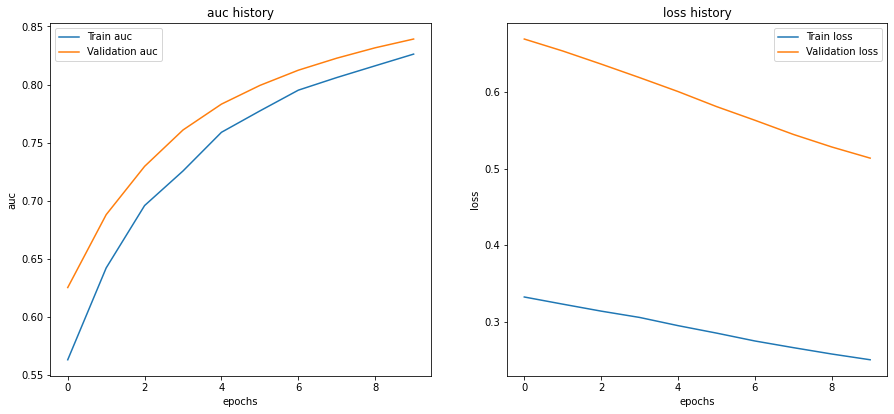

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.839 ± 0.000
Average cv roc average precision 0.941 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 47
Second layer nerons 74
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
47
The number neurons in the second layer
74
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 7s 95ms/step - loss: 0.3256 - auc: 0.6379 - mAP: 0.8221 - val_loss: 0.6470 - val_auc: 0.7711 - val_mAP: 0.9088
Epoch 2/10
51/51 [==============================] - 4s 84ms/step - loss: 0.3056 - auc:

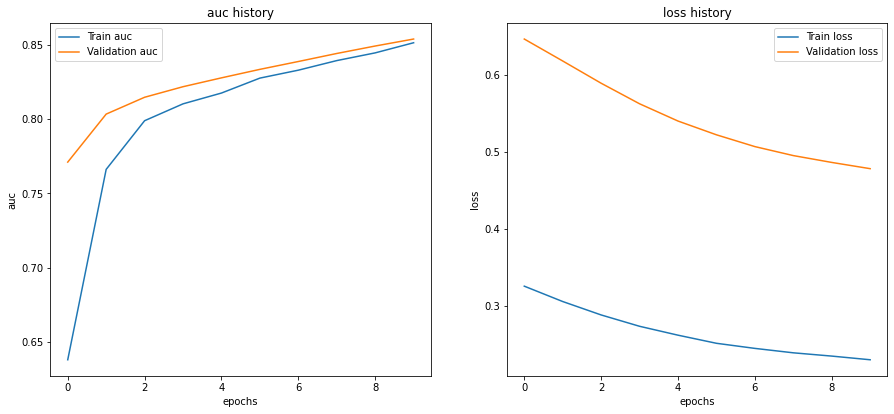

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.854 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 34
Second layer nerons 9
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
34
The number neurons in the second layer
9
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 91ms/step - loss: 0.3539 - auc: 0.6077 - mAP: 0.8076 - val_loss: 0.8553 - val_auc: 0.6488 - val_mAP: 0.8467
Epoch 2/10
51/51 [==============================] - 4s 83ms/step - loss: 0.3

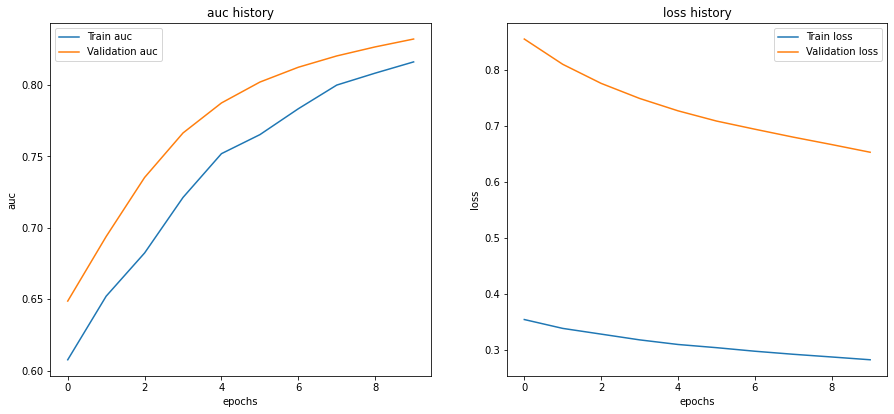

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.832 ± 0.000
Average cv roc average precision 0.932 ± 0.000
Roc auc score OOF 0.537
Average precision OOF 0.817
returnig the avg_score
First layer nerons 26
Second layer nerons 106
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
106
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 93ms/step - loss: 0.3271 - auc: 0.6098 - mAP: 0.8171 - val_loss: 0.6809 - val_auc: 0.7412 - val_mAP: 0.8954
Epoch 2/10
51/51 [==============================] - 4s 84ms/step - loss:

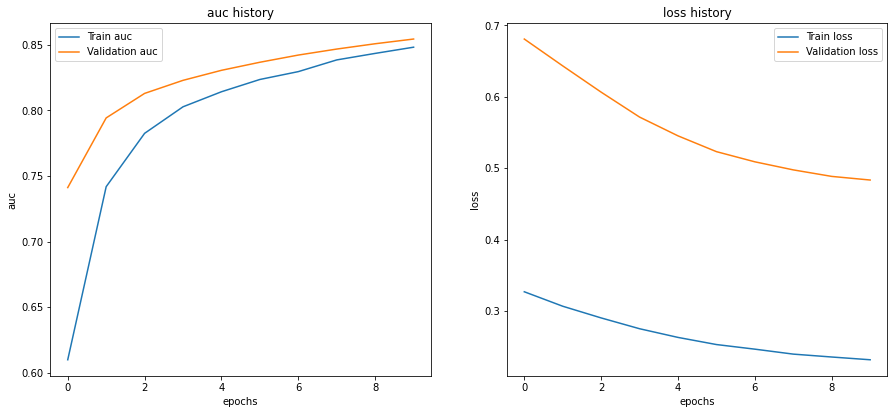

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.855 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 26
Second layer nerons 105
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
105
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 92ms/step - loss: 0.3265 - auc: 0.6346 - mAP: 0.8307 - val_loss: 0.6727 - val_auc: 0.7481 - val_mAP: 0.9050
Epoch 2/10
51/51 [==============================] - 4s 87ms/step - loss: 0.3124 - au

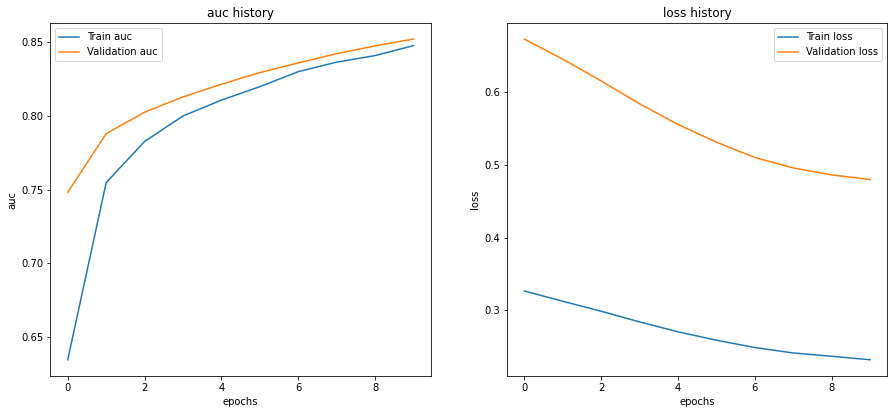

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 58
Second layer nerons 42
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
58
The number neurons in the second layer
42
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 92ms/step - loss: 0.3027 - auc: 0.7269 - mAP: 0.8812 - val_loss: 0.6114 - val_auc: 0.7821 - val_mAP: 0.9143
Epoch 2/10
51/51 [==============================] - 4s 83ms/step - loss: 0

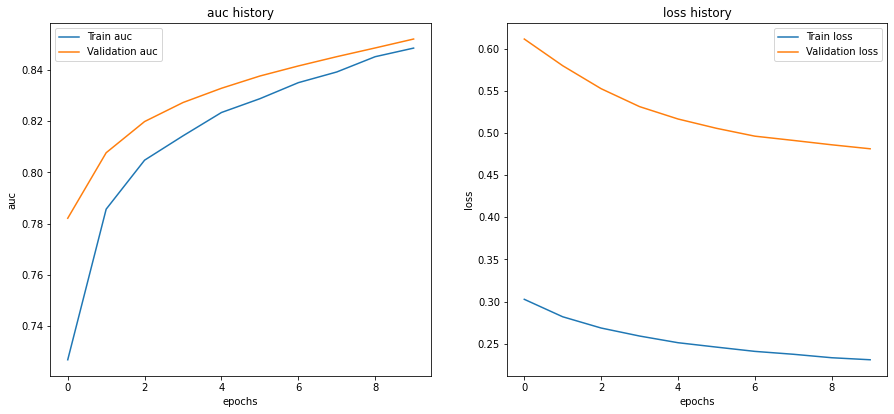

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 58
Second layer nerons 46
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
58
The number neurons in the second layer
46
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 93ms/step - loss: 0.3296 - auc: 0.5630 - mAP: 0.7937 - val_loss: 0.6752 - val_auc: 0.7229 - val_mAP: 0.8990
Epoch 2/10
51/51 [==============================] - 4s 85ms/step - loss: 0

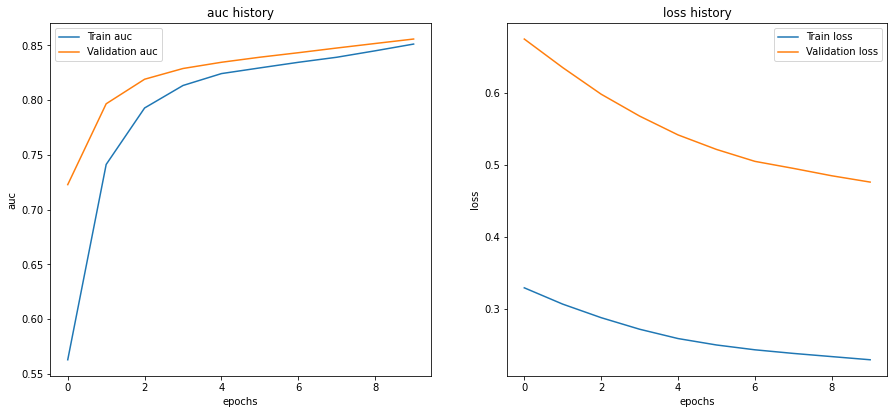

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.856 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 49
Second layer nerons 37
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
49
The number neurons in the second layer
37
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 92ms/step - loss: 0.3500 - auc: 0.4455 - mAP: 0.7467 - val_loss: 0.7003 - val_auc: 0.5461 - val_mAP: 0.8210
Epoch 2/10
51/51 [==============================] - 4s 83ms/step - loss: 0

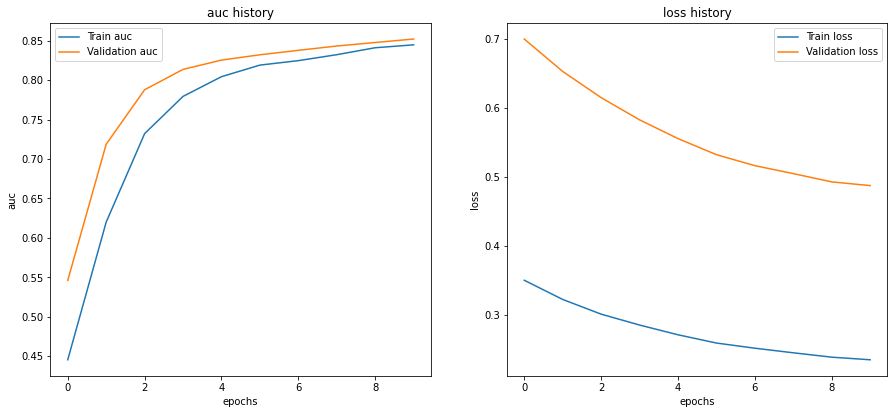

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 26
Second layer nerons 41
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
41
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 93ms/step - loss: 0.3122 - auc: 0.7056 - mAP: 0.8671 - val_loss: 0.6490 - val_auc: 0.7711 - val_mAP: 0.9077
Epoch 2/10
51/51 [==============================] - 4s 87ms/step - loss: 0

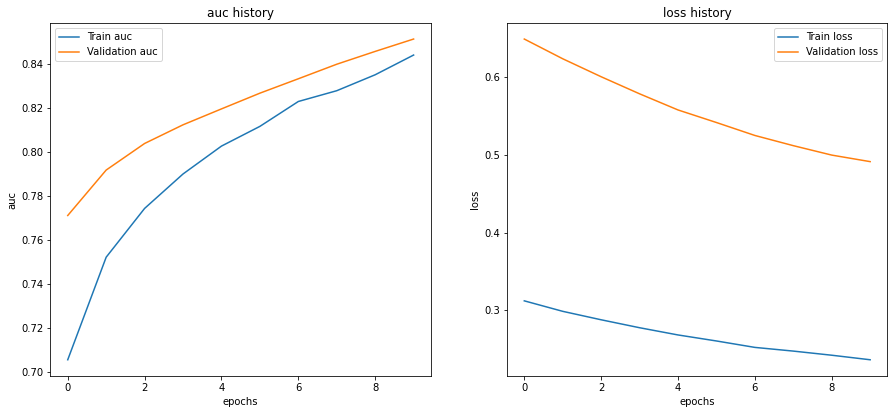

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.851 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 47
Second layer nerons 74
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
47
The number neurons in the second layer
74
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 95ms/step - loss: 0.3231 - auc: 0.6480 - mAP: 0.8388 - val_loss: 0.5966 - val_auc: 0.7549 - val_mAP: 0.9024
Epoch 2/10
51/51 [==============================] - 4s 89ms/step - loss: 0

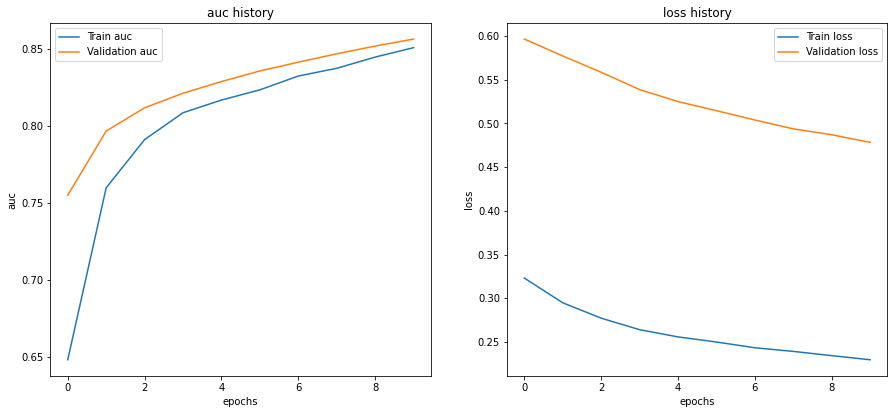

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.856 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
Budget in sec 3600
Train time 1201.5611720085144
First layer nerons 18
Second layer nerons 55
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
18
The number neurons in the second layer
55
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 100ms/step - loss: 0.3235 - auc: 0.6379 - mAP: 0.8306 - val_loss: 0.6327 - val_auc: 0.6806 - val_mAP: 0.8641
Epoch 2/10
51/51 [======

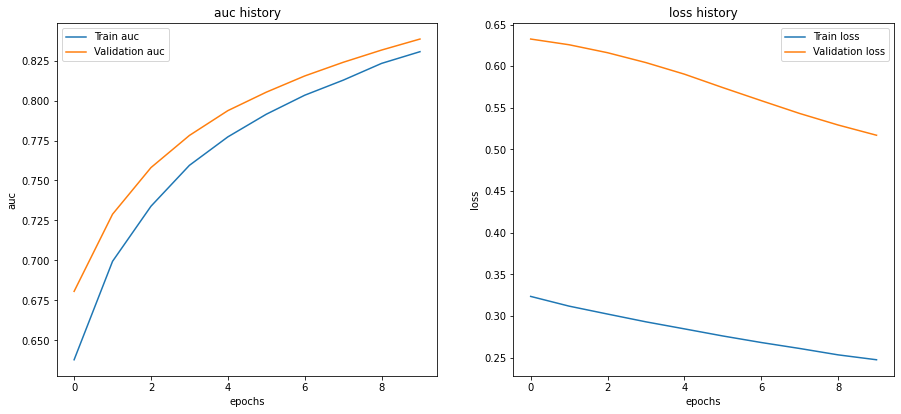

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.838 ± 0.000
Average cv roc average precision 0.940 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 39
Second layer nerons 24
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
39
The number neurons in the second layer
24
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 93ms/step - loss: 0.3576 - auc: 0.4345 - mAP: 0.7308 - val_loss: 0.6628 - val_auc: 0.5011 - val_mAP: 0.7910
Epoch 2/10
51/51 [==============================] - 4s 84ms/step - loss: 0

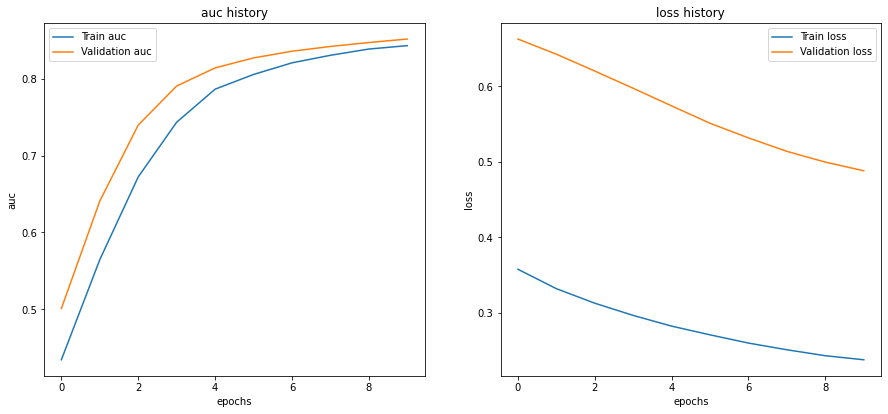

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.851 ± 0.000
Average cv roc average precision 0.944 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 18
Second layer nerons 119
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
18
The number neurons in the second layer
119
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 96ms/step - loss: 0.3294 - auc: 0.5656 - mAP: 0.7945 - val_loss: 0.6843 - val_auc: 0.7111 - val_mAP: 0.8816
Epoch 2/10
51/51 [==============================] - 4s 88ms/step - loss:

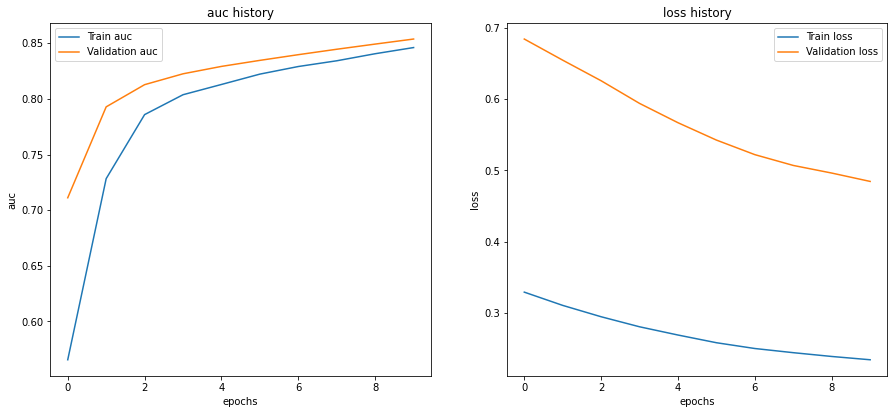

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.854 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 7
Second layer nerons 83
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
7
The number neurons in the second layer
83
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 96ms/step - loss: 0.3371 - auc: 0.4913 - mAP: 0.7584 - val_loss: 0.6717 - val_auc: 0.5448 - val_mAP: 0.8047
Epoch 2/10
51/51 [==============================] - 4s 88ms/step - loss: 0.3

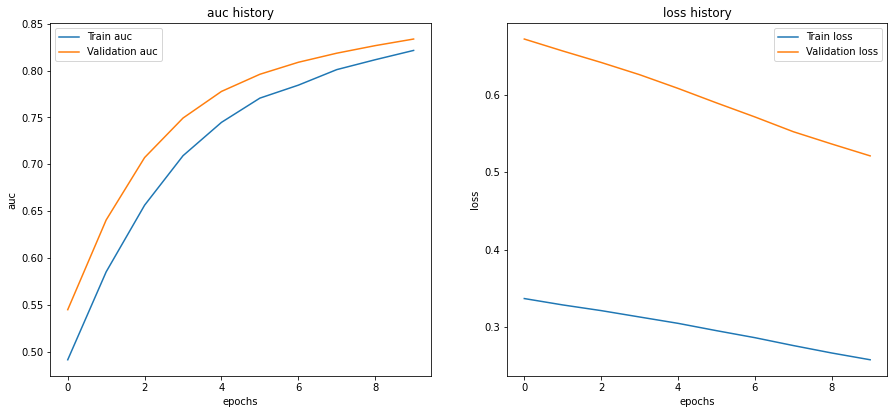

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.834 ± 0.000
Average cv roc average precision 0.933 ± 0.000
Roc auc score OOF 0.537
Average precision OOF 0.817
returnig the avg_score
First layer nerons 18
Second layer nerons 55
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
18
The number neurons in the second layer
55
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 98ms/step - loss: 0.3406 - auc: 0.5103 - mAP: 0.7501 - val_loss: 0.6689 - val_auc: 0.6015 - val_mAP: 0.8148
Epoch 2/10
51/51 [==============================] - 4s 88ms/step - loss: 0

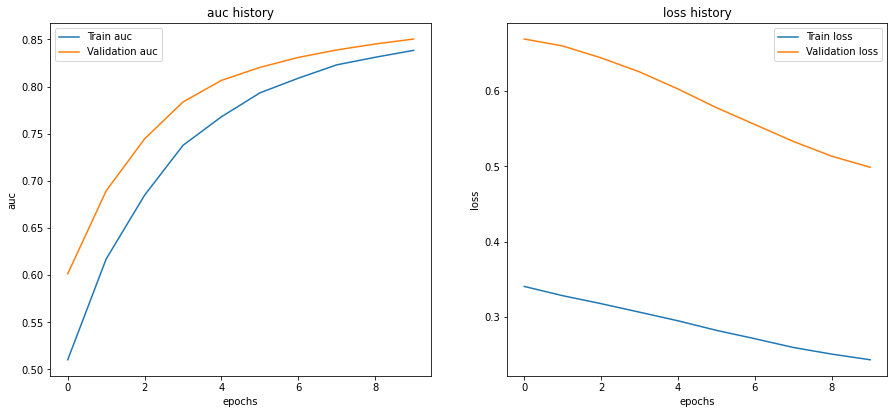

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.850 ± 0.000
Average cv roc average precision 0.944 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 5
Second layer nerons 69
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
5
The number neurons in the second layer
69
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 98ms/step - loss: 0.3330 - auc: 0.5291 - mAP: 0.7875 - val_loss: 0.6641 - val_auc: 0.5904 - val_mAP: 0.8312
Epoch 2/10
51/51 [==============================] - 5s 89ms/step - loss: 0.3

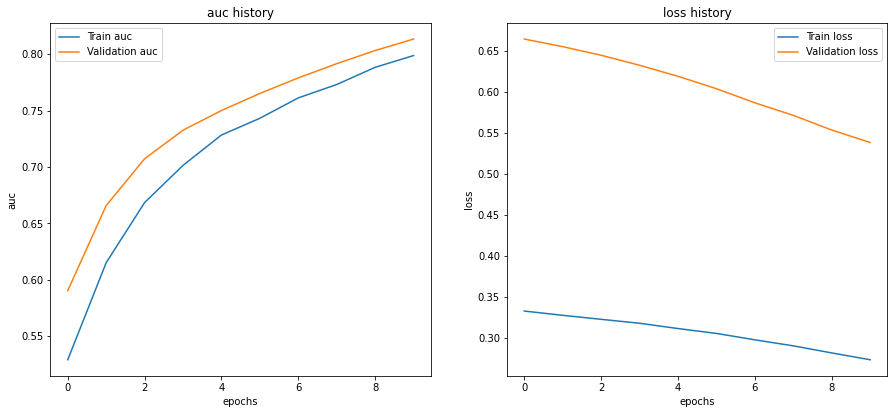

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.813 ± 0.000
Average cv roc average precision 0.926 ± 0.000
Roc auc score OOF 0.535
Average precision OOF 0.815
returnig the avg_score
First layer nerons 39
Second layer nerons 87
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
39
The number neurons in the second layer
87
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 96ms/step - loss: 0.3193 - auc: 0.7089 - mAP: 0.8816 - val_loss: 0.6730 - val_auc: 0.8047 - val_mAP: 0.9282
Epoch 2/10
51/51 [==============================] - 5s 90ms/step - loss: 0.3022 - auc:

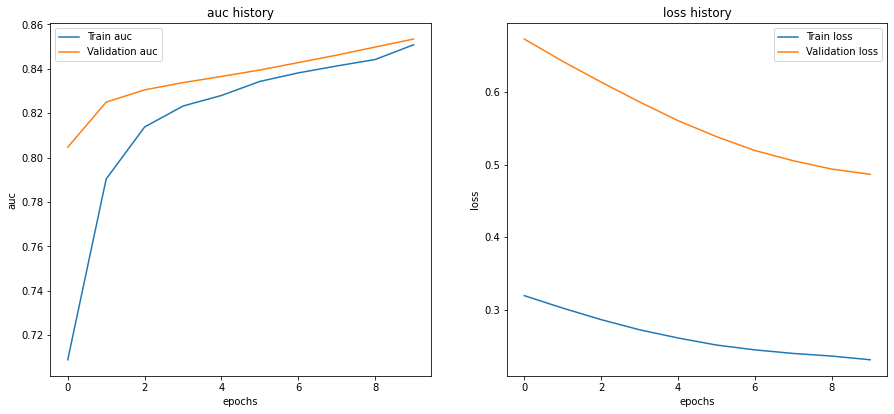

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.853 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 22
Second layer nerons 55
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
22
The number neurons in the second layer
55
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 96ms/step - loss: 0.3285 - auc: 0.5989 - mAP: 0.7998 - val_loss: 0.6999 - val_auc: 0.6817 - val_mAP: 0.8661
Epoch 2/10
51/51 [==============================] - 4s 88ms/step - loss: 0

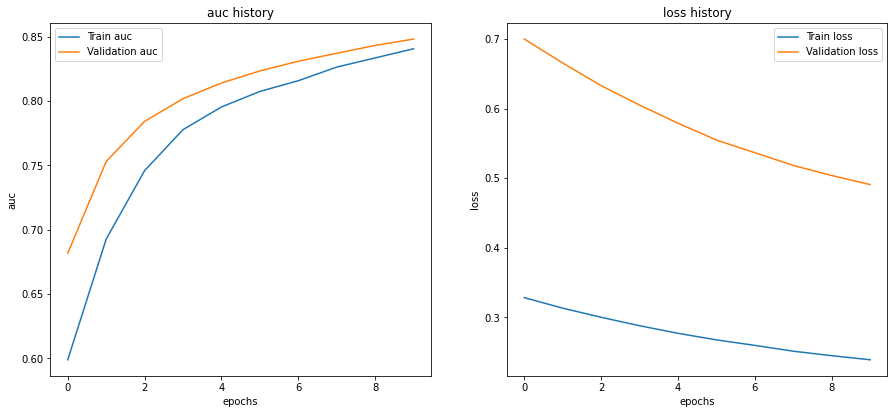

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.848 ± 0.000
Average cv roc average precision 0.944 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 7
Second layer nerons 83
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
7
The number neurons in the second layer
83
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 98ms/step - loss: 0.3333 - auc: 0.5091 - mAP: 0.7662 - val_loss: 0.6691 - val_auc: 0.5556 - val_mAP: 0.8146
Epoch 2/10
51/51 [==============================] - 5s 91ms/step - loss: 0.3

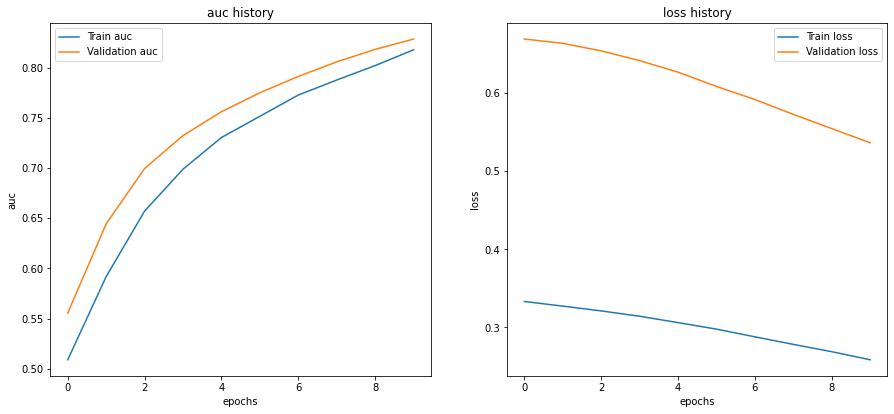

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.828 ± 0.000
Average cv roc average precision 0.935 ± 0.000
Roc auc score OOF 0.536
Average precision OOF 0.818
returnig the avg_score
First layer nerons 17
Second layer nerons 55
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
17
The number neurons in the second layer
55
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 98ms/step - loss: 0.3296 - auc: 0.5687 - mAP: 0.7866 - val_loss: 0.7027 - val_auc: 0.6857 - val_mAP: 0.8620
Epoch 2/10
51/51 [==============================] - 5s 90ms/step - loss: 0

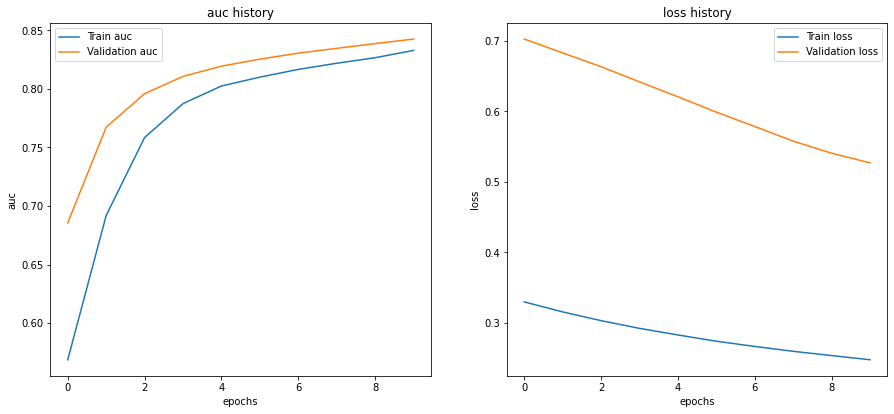

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.843 ± 0.000
Average cv roc average precision 0.940 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
Budget in sec 3600
Train time 1729.639330148697
First layer nerons 26
Second layer nerons 10
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
10
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 7s 99ms/step - loss: 0.3257 - auc: 0.5996 - mAP: 0.8183 - val_loss: 0.6761 - val_auc: 0.6557 - val_mAP: 0.8618
Epoch 2/10
51/51 [========

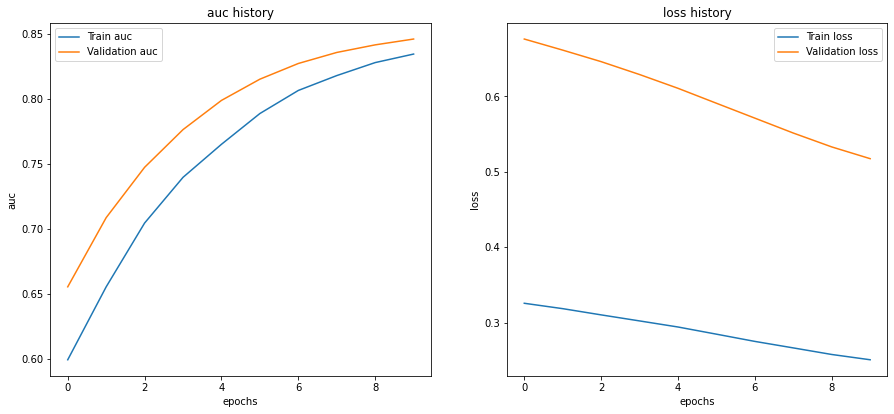

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.846 ± 0.000
Average cv roc average precision 0.943 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.821
returnig the avg_score
First layer nerons 43
Second layer nerons 74
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
43
The number neurons in the second layer
74
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3073 - auc: 0.7190 - mAP: 0.8790 - val_loss: 0.6075 - val_auc: 0.7861 - val_mAP: 0.9160
Epoch 2/10
51/51 [==============================] - 5s 94ms/step - loss: 

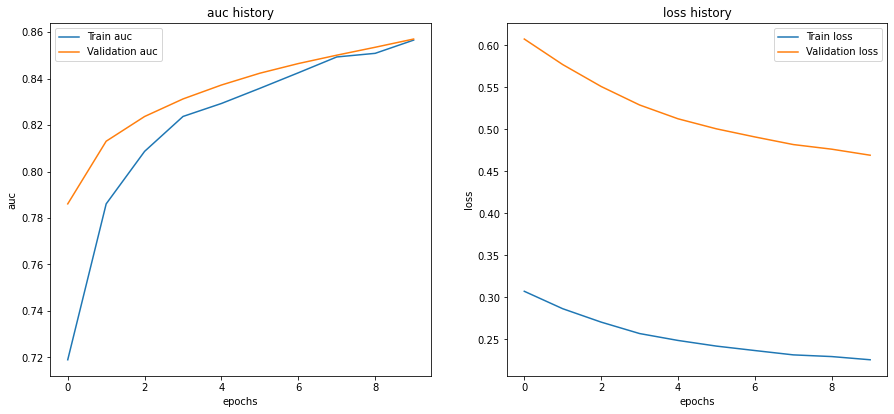

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.857 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 26
Second layer nerons 105
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
105
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 106ms/step - loss: 0.3374 - auc: 0.4921 - mAP: 0.7550 - val_loss: 0.6624 - val_auc: 0.6404 - val_mAP: 0.8502
Epoch 2/10
51/51 [==============================] - 5s 91ms/step - loss

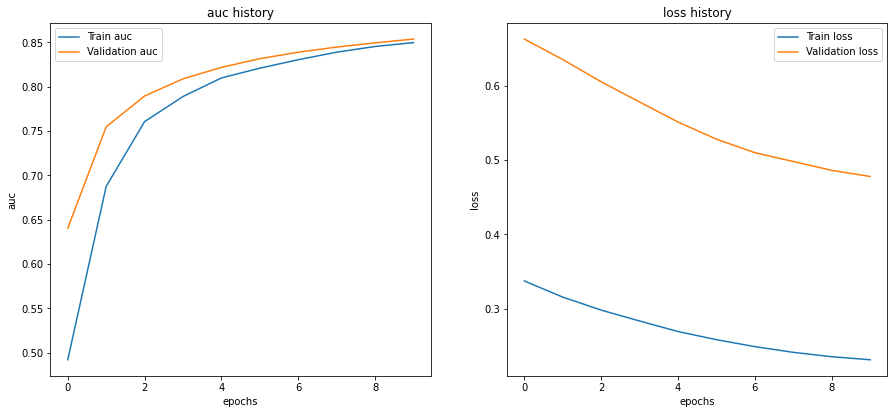

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.854 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 26
Second layer nerons 121
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
121
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 101ms/step - loss: 0.3203 - auc: 0.7035 - mAP: 0.8644 - val_loss: 0.6670 - val_auc: 0.7820 - val_mAP: 0.9174
Epoch 2/10
51/51 [==============================] - 5s 94ms/step - loss: 0.3042 - a

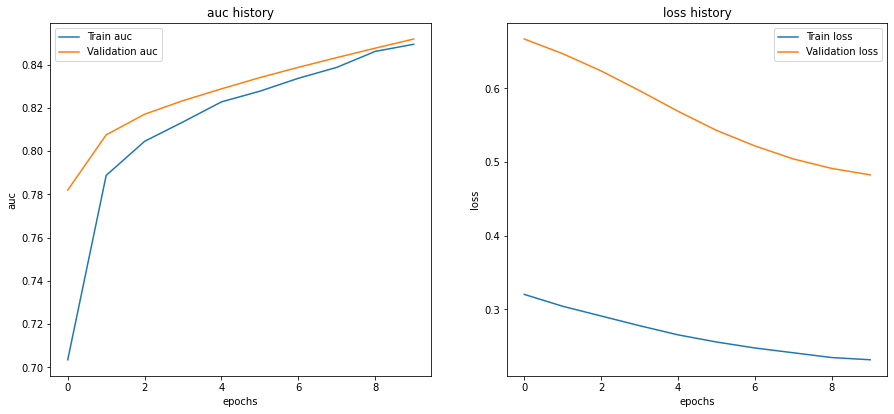

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 47
Second layer nerons 13
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
47
The number neurons in the second layer
13
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 100ms/step - loss: 0.3428 - auc: 0.5136 - mAP: 0.7741 - val_loss: 0.7617 - val_auc: 0.5750 - val_mAP: 0.8197
Epoch 2/10
51/51 [==============================] - 5s 91ms/step - loss: 

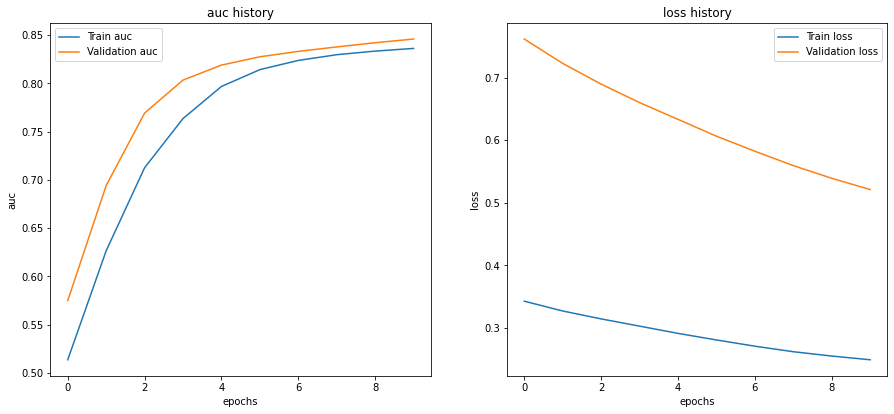

13/13 [==============================] - 0s 8ms/step
Average cv roc auc score 0.846 ± 0.000
Average cv roc average precision 0.943 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.821
returnig the avg_score
First layer nerons 28
Second layer nerons 46
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
28
The number neurons in the second layer
46
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 104ms/step - loss: 0.3638 - auc: 0.3787 - mAP: 0.7070 - val_loss: 0.7384 - val_auc: 0.4034 - val_mAP: 0.7509
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 

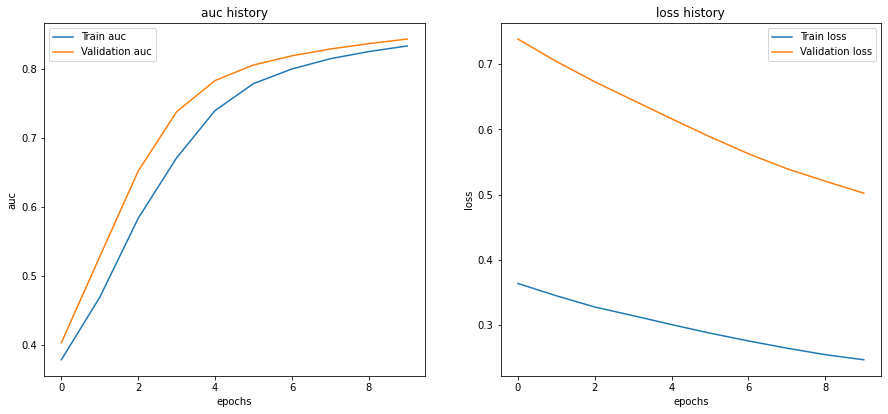

13/13 [==============================] - 0s 7ms/step
Average cv roc auc score 0.843 ± 0.000
Average cv roc average precision 0.941 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 29
Second layer nerons 97
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
29
The number neurons in the second layer
97
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3379 - auc: 0.4654 - mAP: 0.7330 - val_loss: 0.6874 - val_auc: 0.5792 - val_mAP: 0.8150
Epoch 2/10
51/51 [==============================] - 5s 93ms/step - loss: 0.3220 - auc

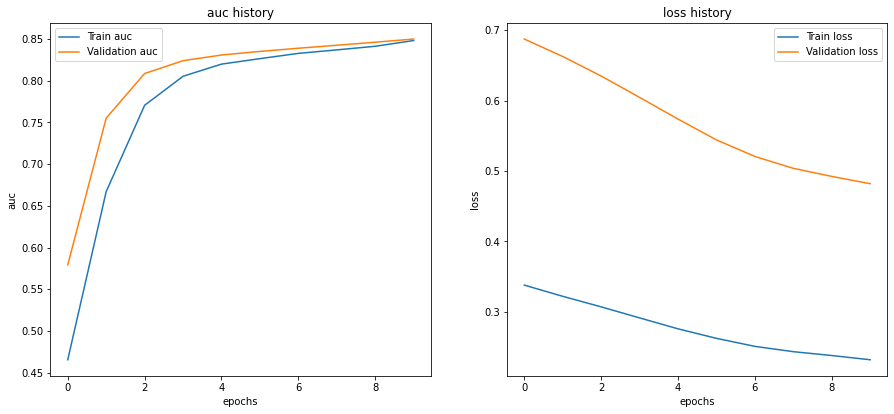

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.850 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 26
Second layer nerons 42
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
42
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3283 - auc: 0.5970 - mAP: 0.8075 - val_loss: 0.6451 - val_auc: 0.6713 - val_mAP: 0.8602
Epoch 2/10
51/51 [==============================] - 5s 93ms/step - loss: 

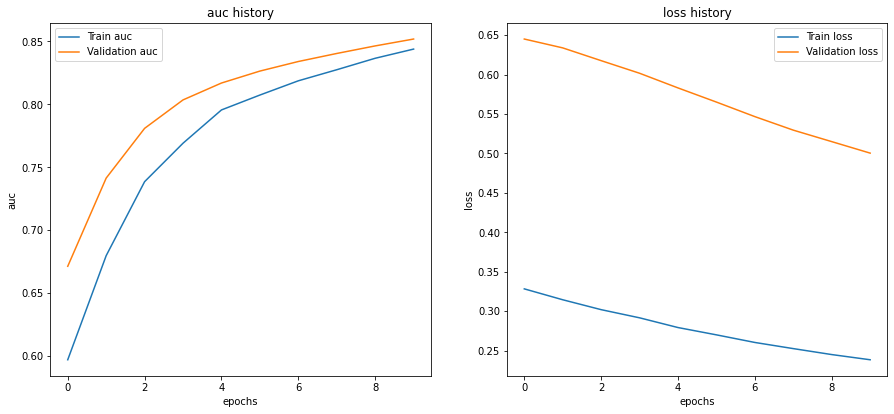

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 26
Second layer nerons 10
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
26
The number neurons in the second layer
10
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 101ms/step - loss: 0.3189 - auc: 0.6603 - mAP: 0.8346 - val_loss: 0.6619 - val_auc: 0.7432 - val_mAP: 0.8975
Epoch 2/10
51/51 [==============================] - 5s 94ms/step - loss: 

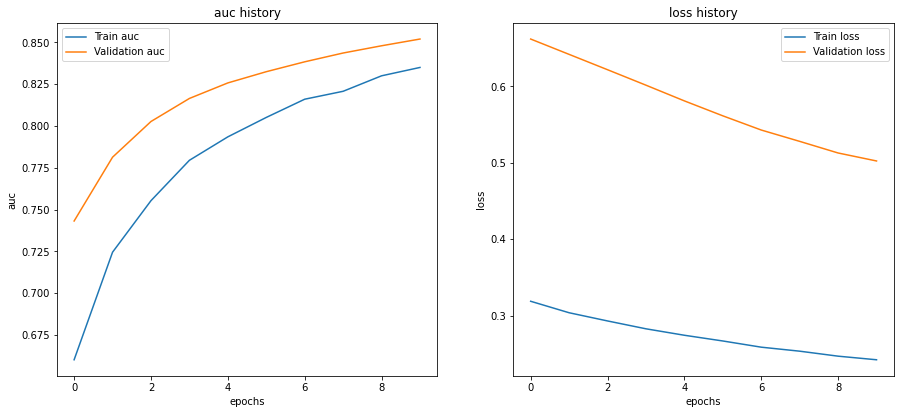

13/13 [==============================] - 0s 4ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 43
Second layer nerons 74
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
43
The number neurons in the second layer
74
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 110ms/step - loss: 0.3389 - auc: 0.4987 - mAP: 0.7606 - val_loss: 0.6682 - val_auc: 0.6312 - val_mAP: 0.8409
Epoch 2/10
51/51 [==============================] - 5s 91ms/step - loss: 

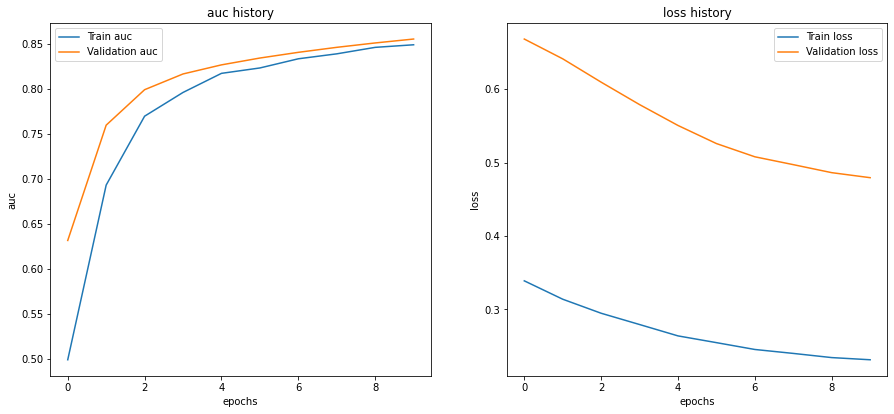

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.855 ± 0.000
Average cv roc average precision 0.948 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
Budget in sec 3600
Train time 2266.7372512817383
First layer nerons 47
Second layer nerons 87
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
47
The number neurons in the second layer
87
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 102ms/step - loss: 0.3235 - auc: 0.6616 - mAP: 0.8377 - val_loss: 0.6365 - val_auc: 0.7829 - val_mAP: 0.9169
Epoch 2/10
51/51 [==================

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



FOLD 0


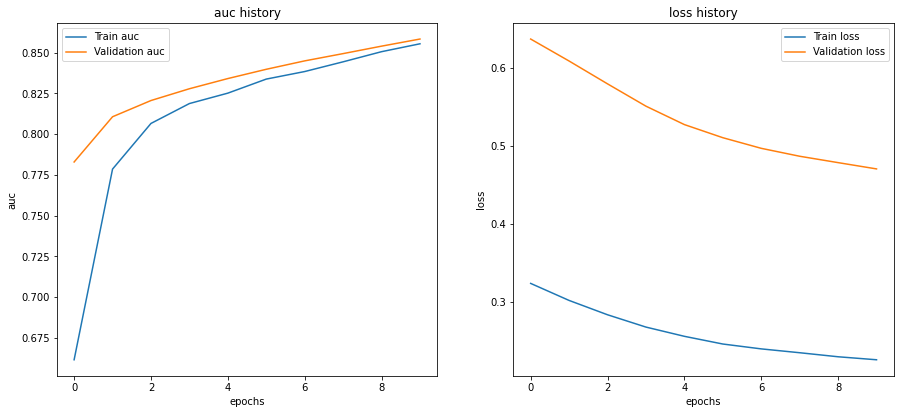

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.858 ± 0.000
Average cv roc average precision 0.948 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 47
Second layer nerons 6
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
47
The number neurons in the second layer
6
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 100ms/step - loss: 0.3667 - auc: 0.4825 - mAP: 0.7442 - val_loss: 0.6259 - val_auc: 0.5285 - val_mAP: 0.7906
Epoch 2/10
51/51 [==============================] - 5s 96ms/step - loss: 0.

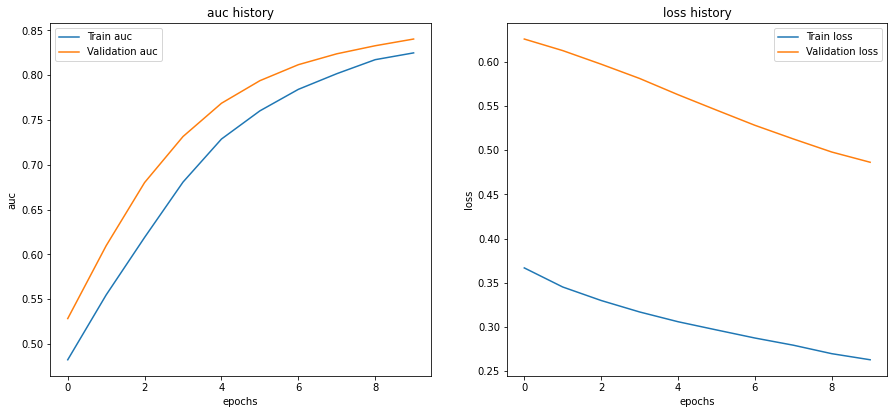

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.840 ± 0.000
Average cv roc average precision 0.942 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 38
Second layer nerons 51
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
38
The number neurons in the second layer
51
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 101ms/step - loss: 0.3179 - auc: 0.6567 - mAP: 0.8314 - val_loss: 0.6393 - val_auc: 0.7377 - val_mAP: 0.8894
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 

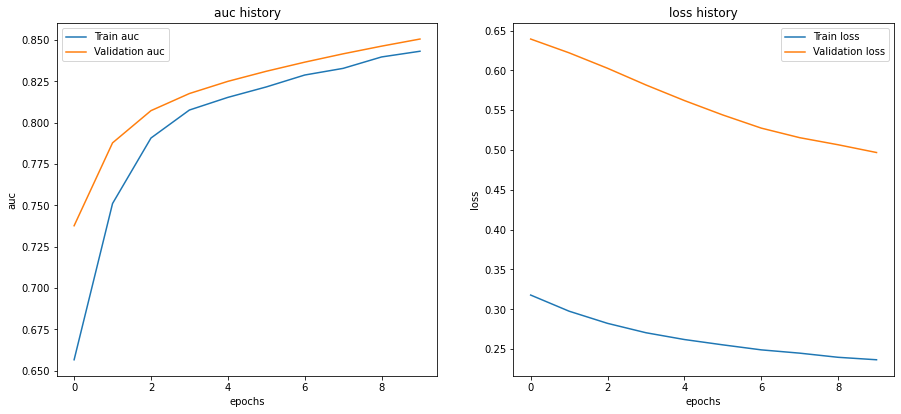

13/13 [==============================] - 0s 7ms/step
Average cv roc auc score 0.851 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 23
Second layer nerons 71
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
23
The number neurons in the second layer
71
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3324 - auc: 0.5413 - mAP: 0.7812 - val_loss: 0.6857 - val_auc: 0.6742 - val_mAP: 0.8679
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 0.3227 - auc

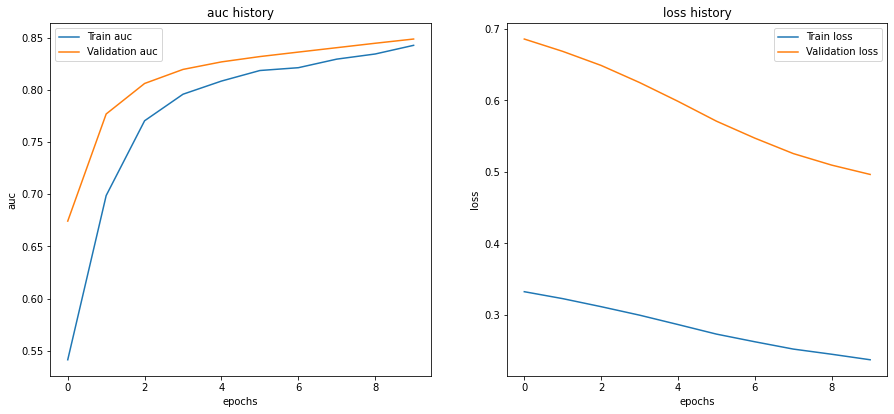

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.849 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 36
Second layer nerons 32
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
36
The number neurons in the second layer
32
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 101ms/step - loss: 0.3278 - auc: 0.6025 - mAP: 0.8007 - val_loss: 0.6661 - val_auc: 0.6917 - val_mAP: 0.8647
Epoch 2/10
51/51 [==============================] - 5s 94ms/step - loss: 

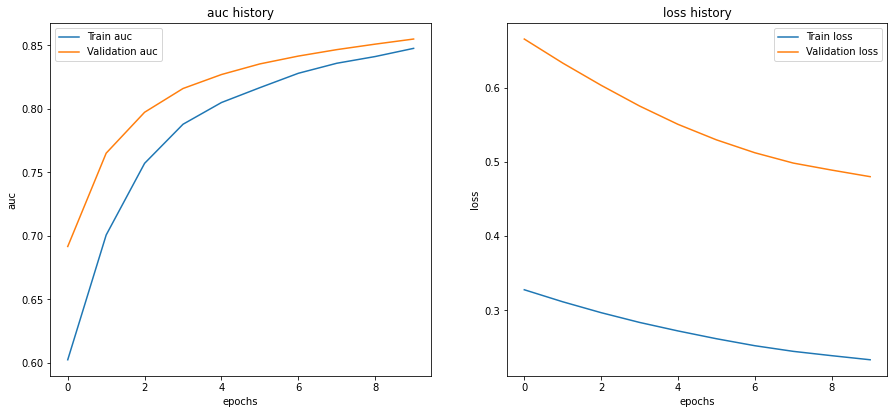

13/13 [==============================] - 0s 7ms/step
Average cv roc auc score 0.855 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 22
Second layer nerons 117
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
22
The number neurons in the second layer
117
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3358 - auc: 0.5087 - mAP: 0.7642 - val_loss: 0.6763 - val_auc: 0.6564 - val_mAP: 0.8599
Epoch 2/10
51/51 [==============================] - 5s 94ms/step - loss

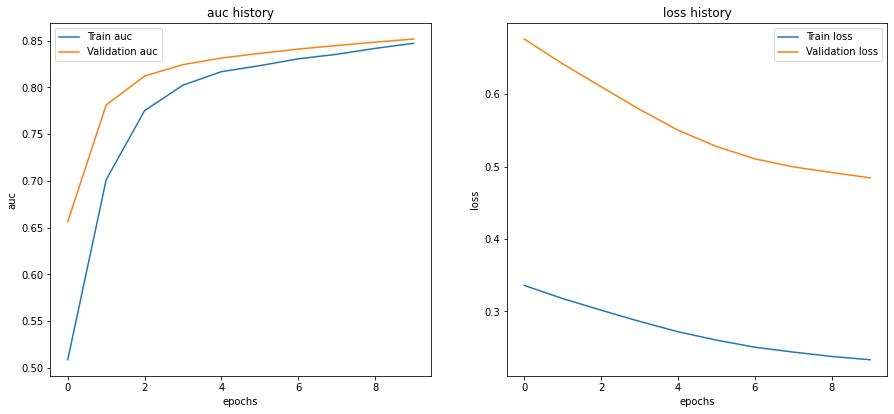

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 39
Second layer nerons 8
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
39
The number neurons in the second layer
8
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3342 - auc: 0.5544 - mAP: 0.7879 - val_loss: 0.6724 - val_auc: 0.6100 - val_mAP: 0.8352
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 0.

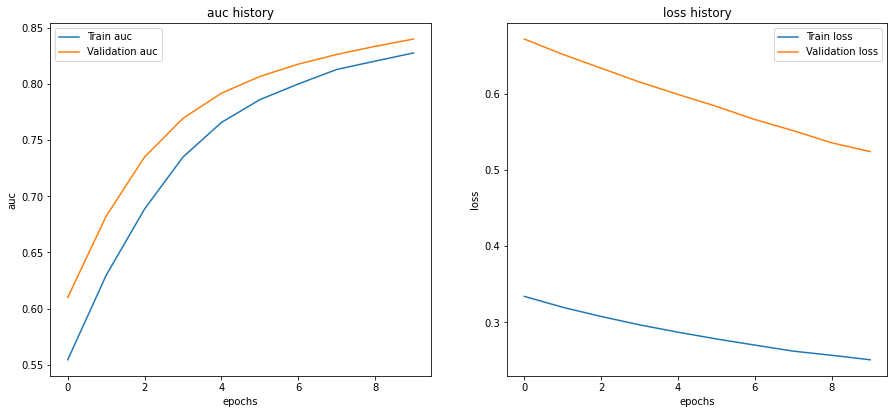

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.840 ± 0.000
Average cv roc average precision 0.938 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.819
returnig the avg_score
First layer nerons 6
Second layer nerons 53
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
6
The number neurons in the second layer
53
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3341 - auc: 0.5071 - mAP: 0.7466 - val_loss: 0.7021 - val_auc: 0.5684 - val_mAP: 0.8095
Epoch 2/10
51/51 [==============================] - 5s 96ms/step - loss: 0.

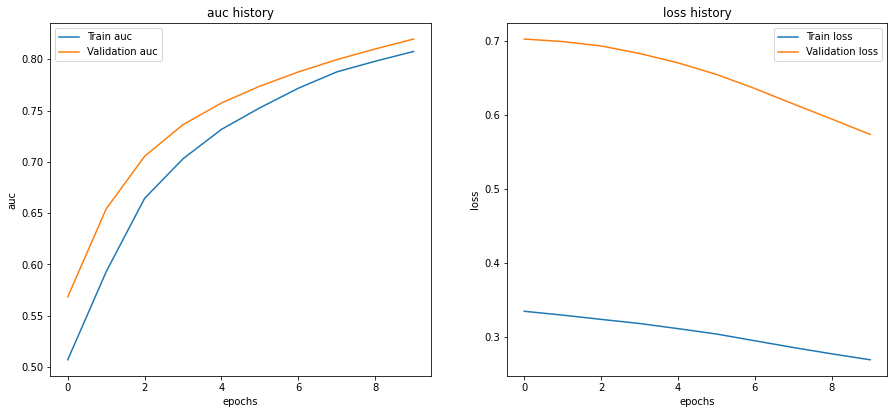

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.820 ± 0.000
Average cv roc average precision 0.931 ± 0.000
Roc auc score OOF 0.535
Average precision OOF 0.817
returnig the avg_score
First layer nerons 22
Second layer nerons 56
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
22
The number neurons in the second layer
56
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 100ms/step - loss: 0.3402 - auc: 0.4705 - mAP: 0.7354 - val_loss: 0.6830 - val_auc: 0.5947 - val_mAP: 0.8231
Epoch 2/10
51/51 [==============================] - 5s 93ms/step - loss: 

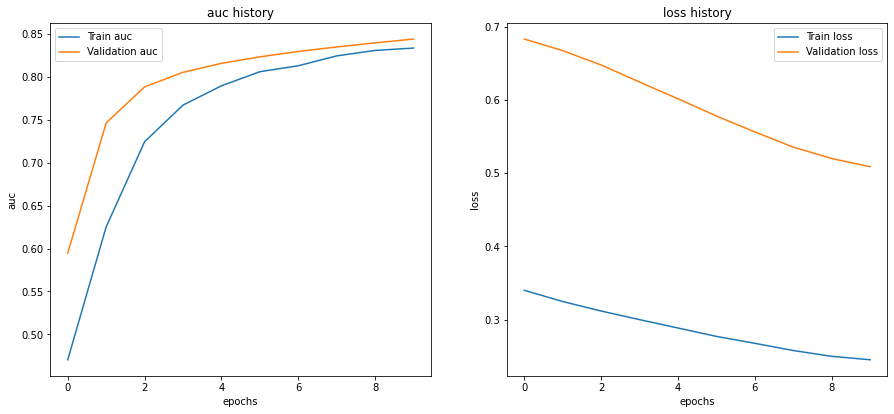

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.844 ± 0.000
Average cv roc average precision 0.942 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 39
Second layer nerons 24
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
39
The number neurons in the second layer
24
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 105ms/step - loss: 0.3371 - auc: 0.5119 - mAP: 0.7677 - val_loss: 0.6613 - val_auc: 0.6048 - val_mAP: 0.8348
Epoch 2/10
51/51 [==============================] - 5s 94ms/step - loss: 

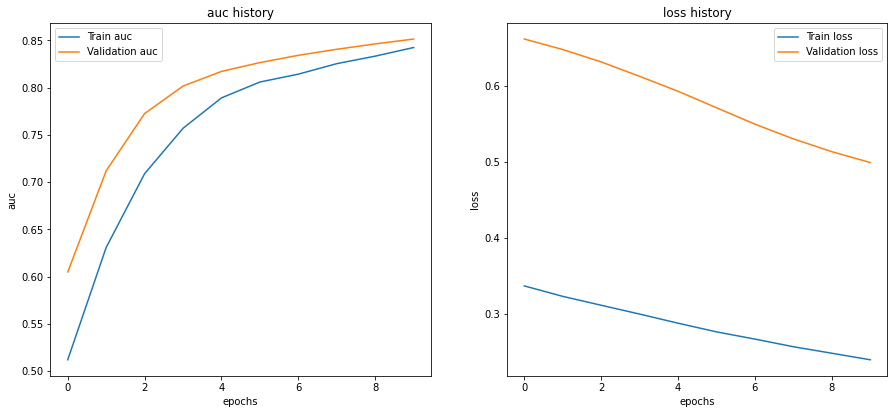

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.852 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
Budget in sec 3600
Train time 2827.3009831905365
>2, new best f([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1]) = 0.681
First layer nerons 43
Second layer nerons 73
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
43
The number neurons in the second layer
73
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 102ms/step - loss: 0.3368 - auc: 0.5047 - mAP: 0.7560 - val_loss: 0.7036 - 

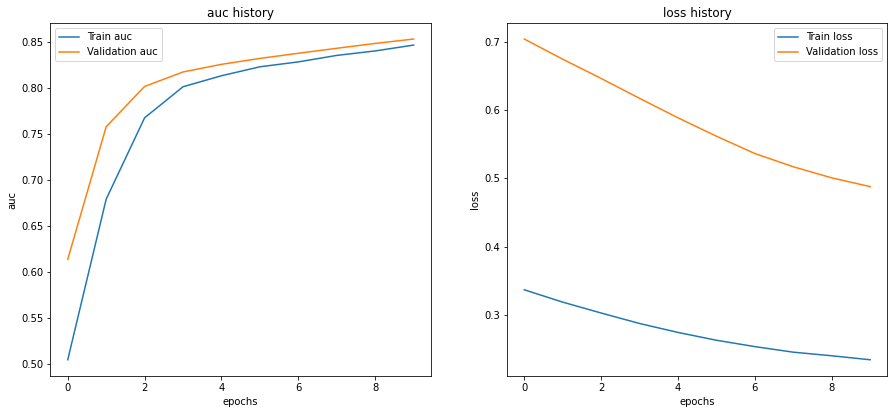

13/13 [==============================] - 0s 8ms/step
Average cv roc auc score 0.853 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 58
Second layer nerons 72
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
58
The number neurons in the second layer
72
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3298 - auc: 0.5751 - mAP: 0.8062 - val_loss: 0.6255 - val_auc: 0.7481 - val_mAP: 0.9035
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 

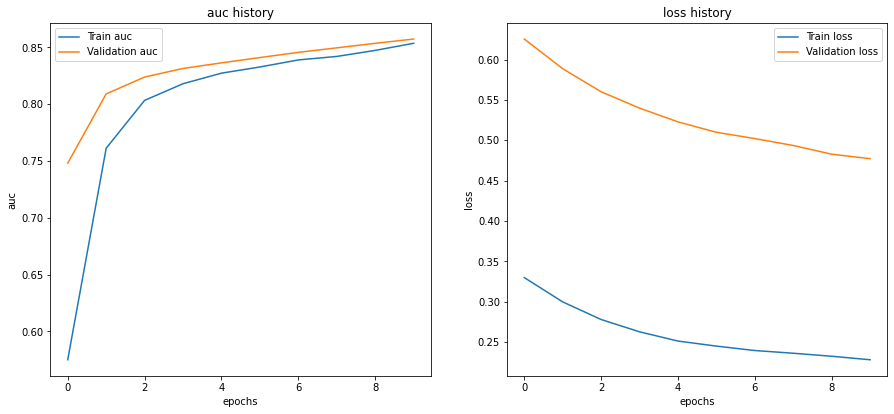

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.857 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 25
Second layer nerons 105
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
25
The number neurons in the second layer
105
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 105ms/step - loss: 0.3082 - auc: 0.7426 - mAP: 0.8952 - val_loss: 0.6425 - val_auc: 0.7868 - val_mAP: 0.9203
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss

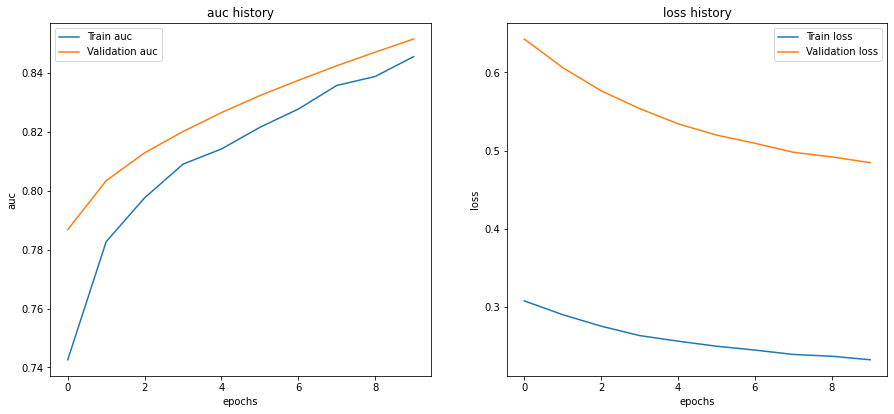

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.851 ± 0.000
Average cv roc average precision 0.946 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.822
returnig the avg_score
First layer nerons 30
Second layer nerons 97
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
30
The number neurons in the second layer
97
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 111ms/step - loss: 0.3324 - auc: 0.5338 - mAP: 0.7766 - val_loss: 0.6761 - val_auc: 0.6445 - val_mAP: 0.8500
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 0.3185 - auc

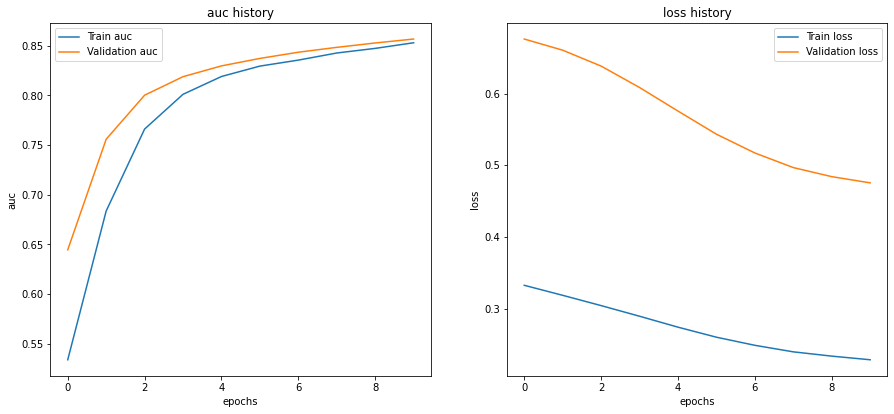

13/13 [==============================] - 0s 7ms/step
Average cv roc auc score 0.857 ± 0.000
Average cv roc average precision 0.948 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 30
Second layer nerons 123
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
30
The number neurons in the second layer
123
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 105ms/step - loss: 0.3431 - auc: 0.4069 - mAP: 0.7029 - val_loss: 0.6785 - val_auc: 0.5484 - val_mAP: 0.7984
Epoch 2/10
51/51 [==============================] - 5s 96ms/step - loss: 0.3268 - a

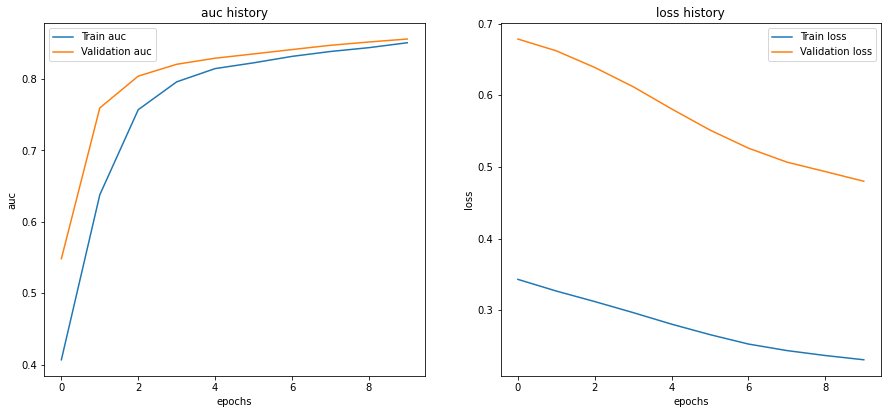

13/13 [==============================] - 0s 7ms/step
Average cv roc auc score 0.856 ± 0.000
Average cv roc average precision 0.948 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 43
Second layer nerons 12
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
43
The number neurons in the second layer
12
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 102ms/step - loss: 0.3301 - auc: 0.5849 - mAP: 0.8037 - val_loss: 0.6612 - val_auc: 0.6666 - val_mAP: 0.8707
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 

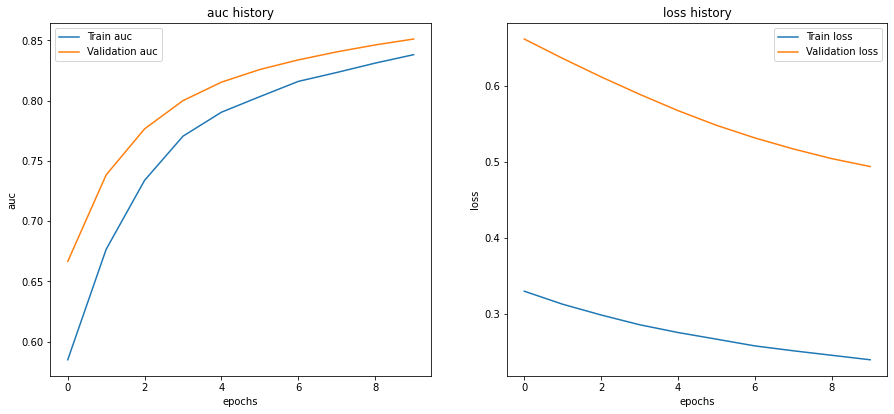

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.851 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
First layer nerons 18
Second layer nerons 58
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
18
The number neurons in the second layer
58
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 105ms/step - loss: 0.3301 - auc: 0.5859 - mAP: 0.8130 - val_loss: 0.7129 - val_auc: 0.6564 - val_mAP: 0.8587
Epoch 2/10
51/51 [==============================] - 5s 96ms/step - loss: 

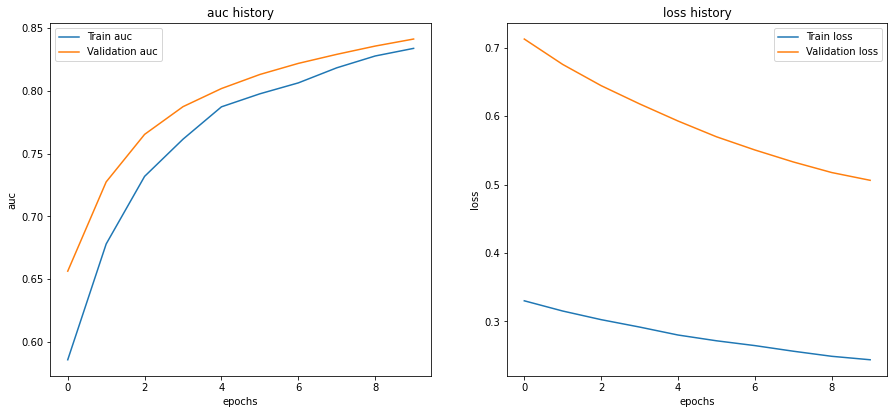

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.841 ± 0.000
Average cv roc average precision 0.940 ± 0.000
Roc auc score OOF 0.538
Average precision OOF 0.820
returnig the avg_score
First layer nerons 29
Second layer nerons 114
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
29
The number neurons in the second layer
114
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3262 - auc: 0.6320 - mAP: 0.8254 - val_loss: 0.6633 - val_auc: 0.7276 - val_mAP: 0.8948
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 0.3135 - a

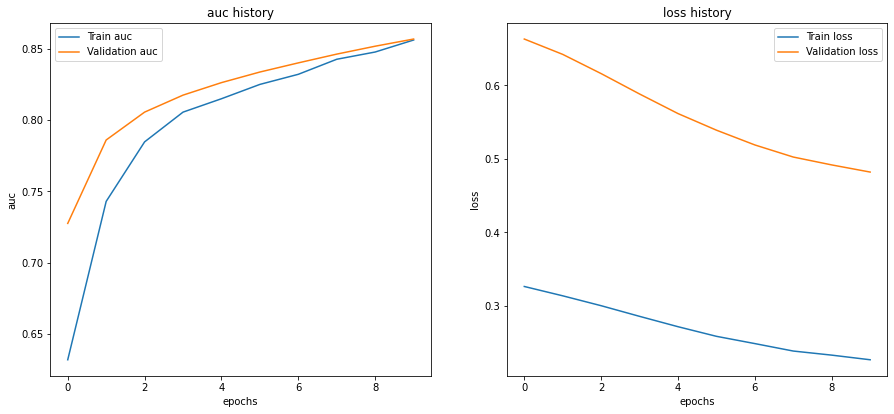

13/13 [==============================] - 0s 6ms/step
Average cv roc auc score 0.857 ± 0.000
Average cv roc average precision 0.947 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.822
returnig the avg_score
First layer nerons 41
Second layer nerons 73
The activation function leaky-relu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
41
The number neurons in the second layer
73
The activation type 
leaky-relu
Epoch 1/10
51/51 [==============================] - 8s 104ms/step - loss: 0.3194 - auc: 0.6715 - mAP: 0.8340 - val_loss: 0.6962 - val_auc: 0.7568 - val_mAP: 0.8982
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



FOLD 0


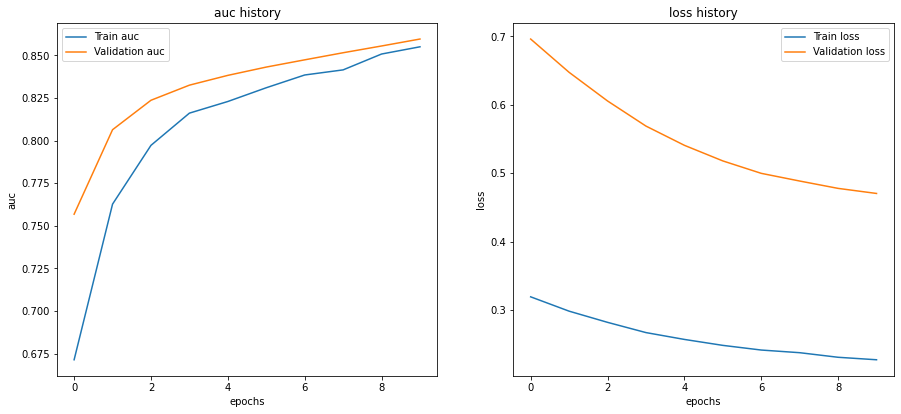

13/13 [==============================] - 0s 5ms/step
Average cv roc auc score 0.860 ± 0.000
Average cv roc average precision 0.949 ± 0.000
Roc auc score OOF 0.540
Average precision OOF 0.823
returnig the avg_score
First layer nerons 43
Second layer nerons 11
The activation function gelu
Input array sizes: [14, 75, 11, 18385, 18, 18, 9, 17, 8, 7, 4, 118, 94, 94, 43]
Categorical levels: {'age': 75, 'workclass': 11, 'fnlwgt': 18385, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 118, 'capital-loss': 94, 'hours-per-week': 94, 'native-country': 43}

The number neurons in the first layer
43
The number neurons in the second layer
11
The activation type 
gelu
Epoch 1/10
51/51 [==============================] - 8s 103ms/step - loss: 0.3127 - auc: 0.6806 - mAP: 0.8528 - val_loss: 0.6277 - val_auc: 0.7376 - val_mAP: 0.8952
Epoch 2/10
51/51 [==============================] - 5s 97ms/step - loss: 0.2981 - auc

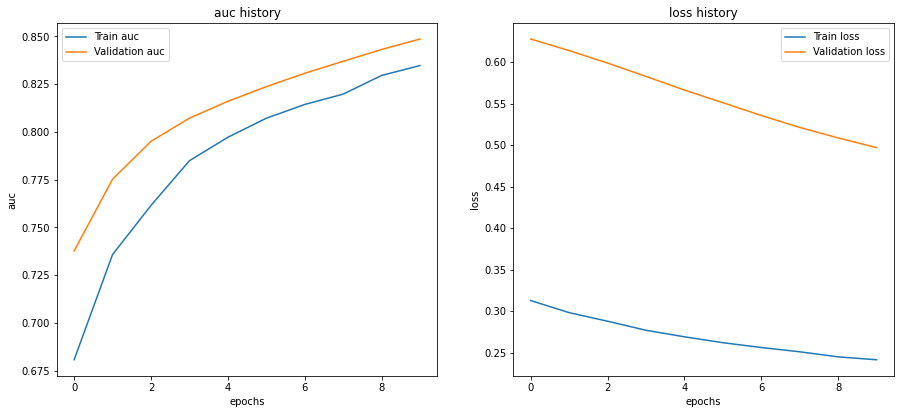

13/13 [==============================] - 0s 8ms/step
Average cv roc auc score 0.849 ± 0.000
Average cv roc average precision 0.945 ± 0.000
Roc auc score OOF 0.539
Average precision OOF 0.821
returnig the avg_score
Budget in sec 3600
Train time 3430.9038560390472
>2, new best f([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]) = 0.681
Done!
f([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]) = 0.681213


In [ ]:
best,categorical_variables,numeric_variables,X_test,y_test,X,y = EvolAutoNN(target,X)

In [ ]:
f_neurons,s_neurons,a_function = decoder(best)

First layer nerons 41
Second layer nerons 73
The activation function leaky-relu


#Testing

In [ ]:
def TestEvolAutoNN(best,categorical_variables,numeric_variables,X_test,y_test,X,y):
  f_neurons,s_neurons,a_function = decoder(best)
  ## We train on all the examples, using a rule of thumb for the number of iterations

  tb = TabularTransformer(numeric = numeric_variables,
                        ordinal = [],
                        lowcat  = [],
                        highcat = categorical_variables)

  tb.fit(X)
  sizes = tb.shape(X)
  categorical_levels = dict(zip(categorical_variables, sizes[1:]))
  print(f"Input array sizes: {sizes}")
  print(f"Categorical levels: {categorical_levels}\n")

  model = tabular_dnn(numeric_variables, categorical_variables,categorical_levels, f_neurons,s_neurons,a_function,
                        feature_selection_dropout=0.1,categorical_dropout=0.1, dense_dropout = 0.1 
                        )
    
  model = compile_model(model, binary_crossentropy, [AUC(name='auc'), mAP], Adam(learning_rate=0.0001))    

  train_batch = DataGenerator(X, y,
                            tabular_transformer=tb,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

  history = model.fit(train_batch,
                    epochs= 11,
                    class_weight={0:1.0, 1:(np.sum(y==0) / np.sum(y==1))},
                    verbose=1)

  #plot_keras_history(history, measures=['auc', 'loss'])

  # Predicting 
  preds = model.predict(tb.transform(X_test[X.columns]),
                      verbose=1,
                      batch_size=1024).flatten()
  preds=np.around(preds).astype(int)
  print("AUC- ROC Score",roc_auc_score(y_true=y_test, y_score=preds))
  print("Average Precision Score",average_precision_score(y_true=y_test, y_score=preds))
  y_true = y_test
  y_pred = preds
  print("accuracy")
  print(accuracy_score(y_true, y_pred))
  print("precision")
  print(average_precision_score(y_true, y_pred))


In [ ]:
test_confirm = input("Do you want test the parameters : ")
if(test_confirm == 'Yes'):
  TestEvolAutoNN(best,categorical_variables,numeric_variables,X_test,y_test,X,y)

  

Do you want test the parameters : Yes
First layer nerons 41
Second layer nerons 73
The activation function leaky-relu
Input array sizes: [14, 76, 11, 24614, 18, 18, 9, 17, 8, 7, 4, 124, 99, 98, 44]
Categorical levels: {'age': 76, 'workclass': 11, 'fnlwgt': 24614, 'education': 18, 'educational-num': 18, 'marital-status': 9, 'occupation': 17, 'relationship': 8, 'race': 7, 'gender': 4, 'capital-gain': 124, 'capital-loss': 99, 'hours-per-week': 98, 'native-country': 44}

The number neurons in the first layer
41
The number neurons in the second layer
73
The activation type 
leaky-relu


# Performance

In [ ]:
!nvidia-smi

In [ ]:
import wandb
wandb.init()

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored